# Анализ показов рекламы в мобильной игре

# Описание задачи

## Общая информация

Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов рекламы:
- int – полноэкранная реклама; 
- banner – горизонтальный баннер, висит внизу экрана пока юзер играет; 
- rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. 

Информация о каждом показе отправляется в аналитику и содержит доход от показа, формат показанной рекламы, рекламную сеть от которой был показ и др.

eCPM – доход за 1000 показов рекламы.

## Задача исследования

Провести исследование показов рекламы с целью понять как отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров.

Ответить на вопросы:
1. Для каждого формата рекламы:
    - построить распределение средних eCPM-ов юзеров
    - отобразить средние eCPM-ы по городам, версиям ОС
    - отобразить суммарные доходы по городам, версиям ОС
2. Учесть статистическую значимость для п.1b. Привести решение и описать его.
3. Описать наблюдения и вывод по исследованию.

Дополнительные задачи:\
Исследовать:
- Какой процент доходов содержит информацию о городе юзера
- Зависит ли eCPM от времени дня

## Информация о датасете

В таблице "us events ad_revenue filtered 03.02-07.02.csv" содержится информация о показах рекламы для юзеров США

- profile_id – id юзера
- event_json содержит данные о событии показа рекламы:
    - ad_type – формат рекламы (int, banner или rv)
    - placement – когда/где был показ рекламы в игре
    - view_index – номер показа конкретного формата рекламы для юзера (не  поддерживается для баннеров)
    - revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000)
    - ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue юзера
    - network_name – рекламная сеть, от которой был показ
    
Остальные столбцы должны быть интуитивно понятны

# Загрузка данных и библиотек

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (12,8)
sns.set_theme(style="darkgrid")

from scipy.stats import pearsonr
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
df = pd.read_csv('C:/Users/Admin/Downloads/us events ad_revenue filtered 03.02-07.02.csv')

In [3]:
df.columns

Index(['profile_id', 'os_version', 'device_manufacturer', 'device_model',
       'device_type', 'device_locale', 'event_name', 'event_json',
       'event_datetime', 'event_timestamp', 'event_receive_datetime',
       'event_receive_timestamp', 'connection_type', 'operator_name',
       'country_iso_code', 'city'],
      dtype='object')

In [4]:
df.shape

(860079, 16)

In [5]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


Сразу распакую event_json и добавлю эти данные в датафрейм

In [6]:
# unpack json to the dataframe
df = df.join(pd.DataFrame(list(json.loads(d).values())[:] for d in df.pop('event_json')))

In [7]:
new_names = {0:'ad_type',
             1:'placement',
             2:'view_index',
             3:'session_view_index',
             4:'cur_ticks',
             5:'session_length',
             6:'revenue',
             7:'ads_ltv',
             8:'ecpm_sma',
             9:'normalized_ecpm_sma',
             10:'value',
             11:'currency',
             12:'ad_country_code',
             13:'network_name',
             14:'ad_unit_id',
             15:'ad_network_placement',
             16:'creativeId'}

In [8]:
df.rename(columns=new_names, inplace=True)
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city,ad_type,placement,view_index,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,banner,,1,0,637795729492245130,705.88070,0.000510,0.487877,0.511508,0.511508,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,banner,,1,0,637795729659949790,722.65120,0.000510,0.488387,0.511389,0.511389,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte,banner,,1,0,637796515863735930,431.81290,0.002386,0.678479,0.928597,0.928597,0.002386,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa,int,next_level,1,1,637797353426827330,125.94960,0.013894,0.013894,13.782633,13.893784,0.013894,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13045364
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN,banner,,1,0,637797357392197840,12.71129,0.006828,0.060571,1.660282,1.660282,0.006828,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMTi5e-h6_UCFUdVwQodt9EIMw


# Первичный анализ

Перед тем как ответить на вопросы исследования я хочу подбронее ознакомиться с данными.
В этой секции я планирую:
- Изучить содержание всех столбцов
- Удостовериться, что данные совпадают с описанием (действительно ли все юзеры из US, есть ли дубликаты в юзерах, etc)
- Проверить данные на аномалии, пропуски
- Отбросить ненужные для целей анализа столбцы
- Изучить распределения данных. Построить гистограммы, боксплоты и столбчатые диаграммы для основных признаков

## Изучение столбцов

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   profile_id               860065 non-null  object 
 1   os_version               860079 non-null  object 
 2   device_manufacturer      860079 non-null  object 
 3   device_model             860079 non-null  object 
 4   device_type              860079 non-null  object 
 5   device_locale            860079 non-null  object 
 6   event_name               860079 non-null  object 
 7   event_datetime           860079 non-null  object 
 8   event_timestamp          860079 non-null  int64  
 9   event_receive_datetime   860079 non-null  object 
 10  event_receive_timestamp  860079 non-null  int64  
 11  connection_type          860079 non-null  object 
 12  operator_name            841200 non-null  object 
 13  country_iso_code         860079 non-null  object 
 14  city

### Анализ пользователей

По информации выше можно заметить, что в столбце имеются пропуски.

In [10]:
df['profile_id'].isna().sum() # check the number of nan values

14

14 записей о показе рекламы не содержат profile_id.

Моей рекомендацией будет проверить систему логирования показов рекламы.\
По какой-то причине для 14 пользователей в аналитику пришли события о показе рекламы без айди юзера.

Далее я изучу число уникальных юзеров в таблице и посмотрю, сколько в среднем рекламы видят юзеры.

In [11]:
df.dropna(subset='profile_id', inplace=True)

In [12]:
print('Число уникальных игроков в датасете: {}'.format(df['profile_id'].nunique()))

Число уникальных игроков в датасете: 4226


In [13]:
df['profile_id'].value_counts()

JL5pmKYe8g7    8486
JLTfZhBE0e3    6571
JL4p0t068V1    5646
JLnrqVfS2Fn    5046
JLxjvw18Qg0    4934
               ... 
JLm6svXrHwU       1
JLytQqxhsuN       1
JLwa1Kxkn6k       1
JMEFrO5FntC       1
JLgvPJq1sOV       1
Name: profile_id, Length: 4226, dtype: int64

Становится понятно, что разные игроки видели разное количество рекламных объявлений.

Изучу распределение игроков в зависимости от того, сколько рекламных объявлений всех типов они увидели за указанный период времени.

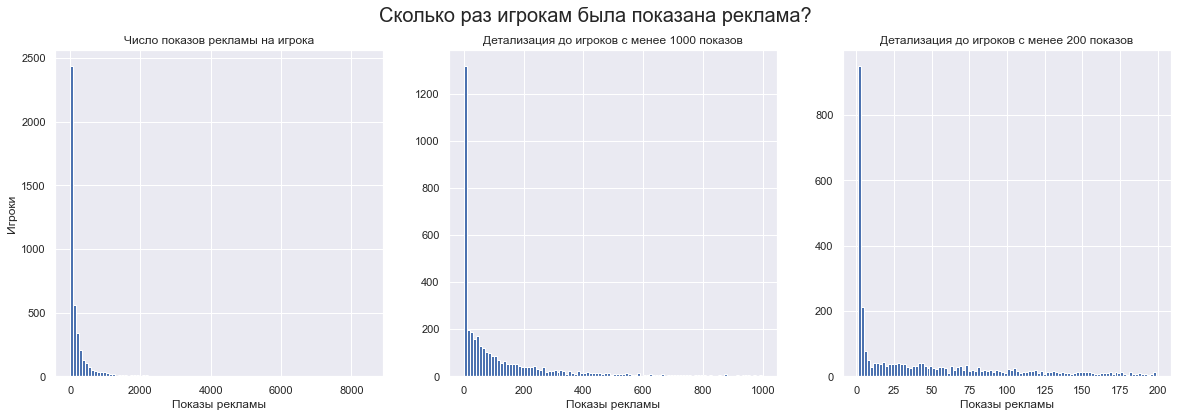

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))
axs[0].hist(x=df['profile_id'].value_counts(), bins=100)
axs[0].set_title('Число показов рекламы на игрока')
axs[0].set_xlabel('Показы рекламы')
axs[0].set_ylabel('Игроки')

axs[1].hist(x=df['profile_id'].value_counts().loc[df['profile_id'].value_counts()<1000], bins=100)
axs[1].set_title('Детализация до игроков с менее 1000 показов')
axs[1].set_xlabel('Показы рекламы')

axs[2].hist(x=df['profile_id'].value_counts().loc[df['profile_id'].value_counts()<200], bins=100)
axs[2].set_title('Детализация до игроков с менее 200 показов')
axs[2].set_xlabel('Показы рекламы')

fig.suptitle('Сколько раз игрокам была показана реклама?', fontsize=20)

plt.show()

По графикам выше становится понятно, что большинство игроков игроков видело рекламу не более 10 раз.\
Примерно после отметки в 200 показов число игроков уменьшается до нескольких десятков.\
Однако в данных имеются и аутлаеры — игроки с тысячами показов рекламы.

На мой взгляд интересно изучить, кто эти игроки и какую рекламу они в основном смотрят.\
Возможно, что эти игроки могут исказить средние значения — например, если они живут в небольших городах с небольшим числом игроков.

Построю боксплоты, чтобы лучше понять, каких игроков уже можно считать за аутлаеров.

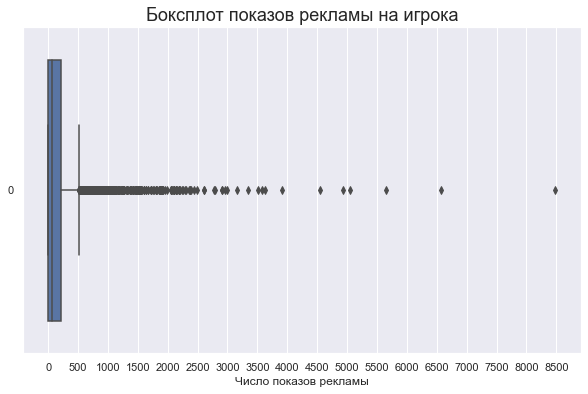

In [15]:
fig, ax = plt.subplots(figsize = (10,6))

ax = sns.boxplot(data=df['profile_id'].value_counts(), orient='h')
ax.set_xlabel("Число показов рекламы")
ax.xaxis.set_ticks(np.arange(0, 9000, 500))

plt.title('Боксплот показов рекламы на игрока', fontsize=18)
plt.show()

In [16]:
n_outliers = len(df['profile_id'].value_counts().loc[df['profile_id'].value_counts()>500]) # number of outliers
outliers_ratio = n_outliers/ df['profile_id'].nunique() # ratio of outliers to all users

print('Число игроков в датасете:', df['profile_id'].nunique())
print('Число игроков с 500+ показов рекламы:', n_outliers)
print()
print('Эти игроки составляют {:.2%} от всех игроков.'.format(outliers_ratio))

Число игроков в датасете: 4226
Число игроков с 500+ показов рекламы: 451

Эти игроки составляют 10.67% от всех игроков.


In [17]:
mean_ads = df['profile_id'].value_counts().mean() # mean number of ads watched by user
median_ads = df['profile_id'].value_counts().median() # median number of ads watched by user

print('Среднее число увиденных рекламных объявлений на игрока: {:.1f}'.format(mean_ads))
print('Медианное число увиденных рекламных объявлений на игрока:', median_ads)

Среднее число увиденных рекламных объявлений на игрока: 203.5
Медианное число увиденных рекламных объявлений на игрока: 57.0


#### Вывод

Игроков c 500+ рекламных показов можно считать аутлаерами.\
Эти игроки образуют 10.67% от всех имеющихся в датасете игроков.

Исследование наиболее активных игроков это идея для интересного ресёрча.\
Сразу напрашиваются вопросы — кто эти игроки, просмотревшие столько рекламных объявлений? Может быть среди них есть боты? Что общего у этих игроков?

Однако сначала я хочу сфокусироваться на основных задачах исследования.

### Анализ девайсов пользователей

В этой секции я изучу имеющуюся информацию о девайсах юзеров:\
os_version, device_manufacturer, device_model, device_type, device_locale

#### os_version

In [18]:
def group_count_function(df, by, column='profile_id'):
    # group by the by column and calculate the number of unique values in the selected column
    new_df =  df.groupby(by)[column].nunique().reset_index().sort_values(by=column, ascending=False).reset_index(drop=True)
    
    # calculate percentage of total profile ids and add it as a column
    new_df['percentage'] = new_df[column] / new_df[column].sum()
    new_df.rename(columns={column:'count'}, inplace=True)
    
    return new_df

In [19]:
os_version_df = group_count_function(df, 'os_version')

In [20]:
def add_percentage(plot, percentage_column):
    """
    Adds data from the percentage_column on top of the bars of the given plot
    """
    for i in range(len(ax.patches)):
        percentage = '{:.1f}%'.format(percentage_column.iloc[i]*100)
        
        x = ax.patches[i].get_x() + ax.patches[i].get_width() / 2 - 0.05
        y = ax.patches[i].get_y() + ax.patches[i].get_height()
        
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

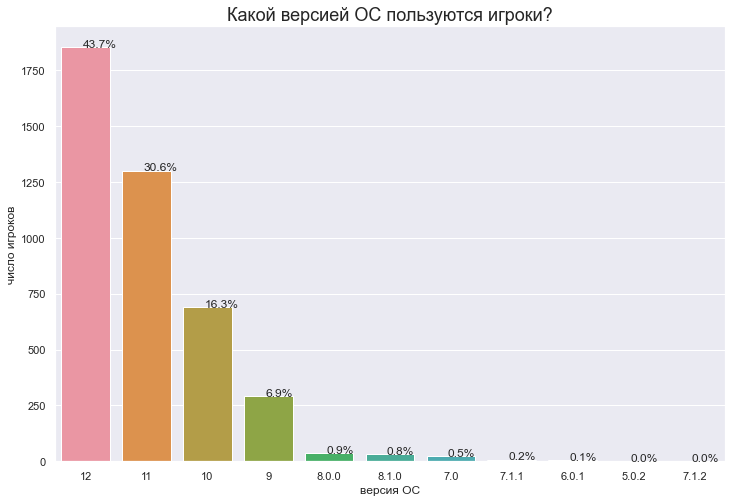

In [21]:
ax=sns.barplot(x='os_version', y='count', data=os_version_df)
plt.title('Какой версией ОС пользуются игроки?', fontsize=18)
plt.ylabel('число игроков')
plt.xlabel('версия ОС')

add_percentage(ax, os_version_df.percentage)

По графику и сводке выше становится видно, что лидирует версия ОС 12 — 43.7% пользователей имеет её.\
Следом идут 11, 10 и 9 версии.

Версии ОС ниже девятой имеют низкую популярность, для упрощения их можно выделить в одну категорию.\
Если поддержка этих версий требует от команды разработки дополнительных усилий, то возможно имеет смысл остановить поддержку версий старее девятой.

In [23]:
df.loc[~df['os_version'].isin(['12','11','10','9']), ['os_version']] = 'lower'

#### device_manufacturer

In [24]:
device_manufacturer_df = group_count_function(df, 'device_manufacturer')

In [25]:
n_unique_manufacturers = device_manufacturer_df.device_manufacturer.nunique()

print('В датасете имеется {} разных производителей девайсов, которыми пользуются игроки'.format(n_unique_manufacturers))

В датасете имеется 34 разных производителей девайсов, которыми пользуются игроки


In [26]:
device_manufacturer_df.head(10)

,device_manufacturer,count,percentage
0,Samsung,3214,0.760530
1,Motorola,323,0.076432
2,Google,300,0.070989
3,LG,176,0.041647
4,OnePlus,84,0.019877
5,T-Mobile,40,0.009465
6,TCL,12,0.002840
7,Alcatel,11,0.002603
8,Cricket,9,0.002130
9,Nokia,7,0.001656


По сводке выше видно, что большая часть пользователей пользуется девайсами Самсунг — 76%

Далее идут Motorola, Google и LG. Становится очевидно, что данные содержат информацию о показе рекламы только на устройствах с ОС Android.

Остальные компании имеют незначительное число пользователей. Для облегчения анализа объединю их в одну категорию "other"

In [27]:
# change all 'device_manufacturer' that are not in the list to 'Other'
device_manufacturer_df.loc[~device_manufacturer_df['device_manufacturer'].isin(['Samsung', 'Google', 'Motorola', 'LG']), ['device_manufacturer']] = 'Other'

In [28]:
aggregation_functions = {'count': 'sum', 'percentage': 'sum'}
device_manufacturer_df = device_manufacturer_df.groupby(device_manufacturer_df['device_manufacturer']).aggregate(aggregation_functions)

In [29]:
device_manufacturer_df.sort_values(by='count', ascending=False, inplace=True)
device_manufacturer_df.reset_index(inplace=True)

In [30]:
device_manufacturer_df

,device_manufacturer,count,percentage
0,Samsung,3214,0.760530
1,Motorola,323,0.076432
2,Google,300,0.070989
3,Other,213,0.050402
4,LG,176,0.041647


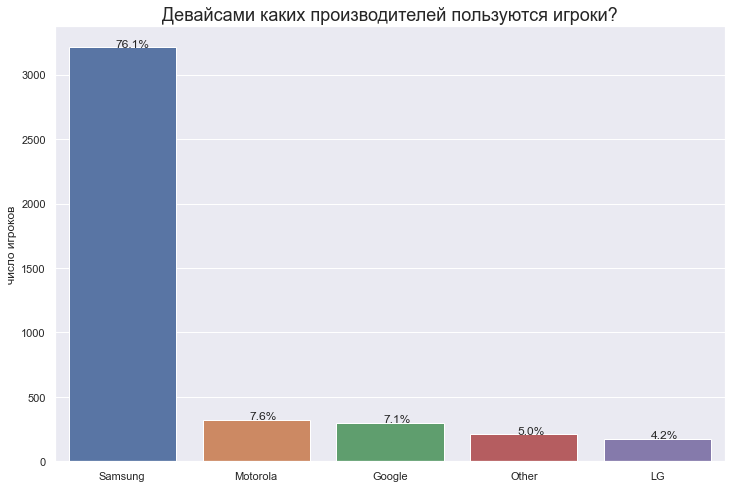

In [31]:
ax=sns.barplot(x='device_manufacturer', y='count', data=device_manufacturer_df)
plt.title('Девайсами каких производителей пользуются игроки?', fontsize=18)
plt.ylabel('число игроков')
plt.xlabel('')

add_percentage(ax, device_manufacturer_df.percentage)

**Вывод**

Мобильная игра особенна популярна среди пользователей девайсов Samsung — 3214 игроков или 76% из всех игроков в датасете.

#### device_model

In [32]:
unique_device_models = df.device_model.nunique()

print('Число уникальных моделей девайсов: {}.'.format(unique_device_models))

Число уникальных моделей девайсов: 284.


In [33]:
device_model_df = group_count_function(df, 'device_model')

In [34]:
device_model_df.head(10)

,device_model,count,percentage
0,SM-G991U,240,0.056791
1,Galaxy S21 Ultra 5G,220,0.052059
2,Galaxy S20 FE 5G,189,0.044723
3,Galaxy S9,174,0.041174
4,Galaxy S10,164,0.038807
5,Galaxy S10e,150,0.035495
6,Galaxy S10+,137,0.032418
7,Galaxy S9+,129,0.030525
8,SM-G996U,117,0.027686
9,Galaxy Note9,104,0.024610


Информация в этой колонке совпадает по своему смыслу с предыдущей колонкой — в топе ожидаемо находятся девайсы компании Samsung

#### device_type

In [35]:
device_type_df = group_count_function(df, 'device_type')

In [36]:
device_type_df

,device_type,count,percentage
0,phone,4011,0.923768
1,tablet,331,0.076232


In [37]:
print('В мобильную игру на телефонах играет {} человек. Это {:.2%} от всех пользователей'.format(device_type_df['count'].iloc[0], 
                                                                                                 device_type_df['percentage'].iloc[0]))

print('В мобильную игру на планшетах играет {} человек. Это {:.2%} от всех пользователей'.format(device_type_df['count'].iloc[1], 
                                                                                                 device_type_df['percentage'].iloc[1]))


В мобильную игру на телефонах играет 4011 человек. Это 92.38% от всех пользователей
В мобильную игру на планшетах играет 331 человек. Это 7.62% от всех пользователей


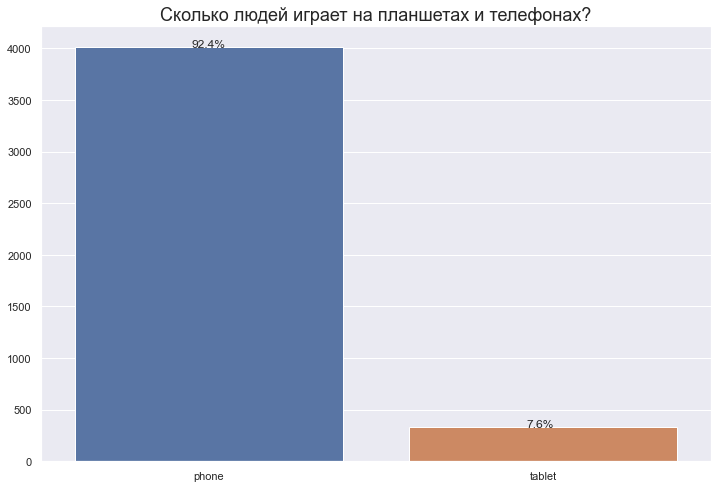

In [38]:
ax=sns.barplot(x='device_type', y='count', data=device_type_df)
plt.title('Сколько людей играет на планшетах и телефонах?', fontsize=18)
plt.ylabel('')
plt.xlabel('')

add_percentage(ax, device_type_df.percentage)

Подавляющее число игроков играет в эту мобильную игру с телефонов

#### device_locale

In [39]:
print('Число уникальных локализаций:', df.device_locale.nunique())

Число уникальных локализаций: 9


In [40]:
device_locale_df = group_count_function(df, 'device_locale')

In [41]:
device_locale_df

,device_locale,count,percentage
0,en_US,4197,0.993138
1,en_CA,12,0.002840
2,en_GB,9,0.002130
3,en_IN,2,0.000473
4,fr_FR,2,0.000473
5,en_AU,1,0.000237
6,en_NL,1,0.000237
7,ko_KR,1,0.000237
8,zh-Hant_TW,1,0.000237


99% игроков имеет английскую американскую локализацию на девайсе.\
Несколько человек имеют другие версии английской локализации.

Только 4 человека пользуются другими локализациями: двое французской и по одному корейской и китайской.

#### Вывод

В этой секции я изучил пользователей по девайсам, которыми они пользуются.

Я выяснил, что наиболее популярные версии ОС: 12, 11, 10 и 9.\
Остальные версии ОС можно объединить в одну категорию, так-как ими пользуется очень мало людей, суммарно около ста человек.\
Если поддержка этих версий требует от команды разработки дополнительных усилий, то моей рекомендацией будет рассмотреть остановку поддержки версий ниже девятой.

Самыми популярными девайсами являются девайсы от компании Samsung — 76% пользователей имеют их.

Игра наиболее популярна на телефонах 92.4% всех пользователей играют с телефонов, только 300 человек из 4226 играют с планшетов.

Все игроки за исключением четырех человек используют английский язык в качестве языка системы на своем девайсе.

### event_name

In [43]:
df.event_name.nunique()

1

In [44]:
df.event_name.iloc[0]

'c_ad_revenue'

Удостоверился, что все записи в таблице — события получения прибыли с показа рекламы.
Могу удалить этот столбец.

In [45]:
df.drop(columns='event_name', inplace=True)

### Время просмотра рекламы

event_datetime столбец потребуется мне ждя оценки eCPM от времени дня.

Сразу переведу его в формат времени и извлеку часы, чтобы визуализировать eCPM для каждого часа.

In [46]:
df.event_datetime = pd.to_datetime(df.event_datetime)
df['event_hour'] = df.event_datetime.dt.hour

In [47]:
period_start = df.event_datetime.dt.date.min()
period_end = df.event_datetime.dt.date.max()

print('В датасете собраны данные за период с {} по {}'.format(period_start, period_end))

В датасете собраны данные за период с 2022-01-29 по 2022-02-07


То есть у меня имеются данные за 10 дней — с 29 января по седьмое февраля.

### Название оператора, connection_type и код страны

#### connection_type

In [48]:
df.connection_type.value_counts()

wifi       624407
cell       235586
unknown        72
Name: connection_type, dtype: int64

In [49]:
connection_type_df = group_count_function(df, 'connection_type')
connection_type_df

,connection_type,count,percentage
0,wifi,3229,0.632889
1,cell,1867,0.365935
2,unknown,6,0.001176


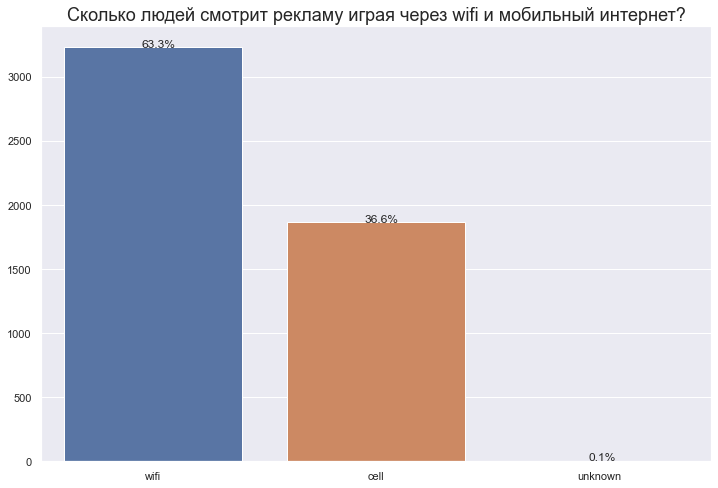

In [50]:
ax=sns.barplot(x='connection_type', y='count', data=connection_type_df)
plt.title('Сколько людей смотрит рекламу играя через wifi и мобильный интернет?', fontsize=18)
plt.ylabel('')
plt.xlabel('')

add_percentage(ax, connection_type_df.percentage)

Чаще люди играют через вайфай — 63.3% случаев.

Можно предположить, что они делают это дома или находясь в других помещениях.

В 36.6% случаев люди пользуются мобильным интернетом — вероятнее всего коротая время в дороге или ожидая чего-то.\
Можно предположить, что игра не требует много времени и в нее можно зайти буквально на пару минут.

В 6 случаях не удалось установить тип подключения. Возможно, что-то пошло не так во время сбора логов.

#### operator_name

In [51]:
print('Число уникальных операторов связи: {}.'.format(df.operator_name.nunique()))

Число уникальных операторов связи: 92.


In [52]:
print('Пропусков в данных об операторах связи: {}.'.format(df.operator_name.isna().sum()))

Пропусков в данных об операторах связи: 18879.


Эта колонка не потребуется для дальнейшего анализа.

Также стоит обратить внимание на пропуски в этой колонке — по какой-то причине не у всех пользователей логгируется их оператор связи.\
Возможно, что это могут блокировать VPN сервисы.

In [53]:
df.drop(columns='operator_name', inplace=True)

#### country_code

In [54]:
print('Число уникальных стран: {}.'.format(df.country_iso_code.nunique()))

Число уникальных стран: 1.


Все данные действительно собраны только по пользователям из США.

In [55]:
df.drop(columns='country_iso_code', inplace=True)

### Города

In [56]:
print('Число уникальных городов: {}.'.format(df.city.nunique()))

Число уникальных городов: 920.


In [57]:
nan_cities = df.city.isna().sum()

print('Пропусков в данных о городе пользователя: {}.'.format(nan_cities))
print('Пропуски составляют {:.2%} от всех данных.'.format(nan_cities/df.shape[0]))

Пропусков в данных о городе пользователя: 323694.
Пропуски составляют 37.64% от всех данных.


Довольно много пропусков в данных — только 62.36% записей о показах содержат информацию о городе пользователя.

In [58]:
city_df = group_count_function(df, 'city')
city_df.head(10)

,city,count,percentage
0,Minneapolis,86,0.024734
1,New York,80,0.023008
2,Chicago,68,0.019557
3,Denver,61,0.017544
4,Houston,60,0.017256
5,Charlotte,56,0.016106
6,Dallas,51,0.014668
7,Los Angeles,49,0.014093
8,Seattle,46,0.013230
9,St. Louis,41,0.011792


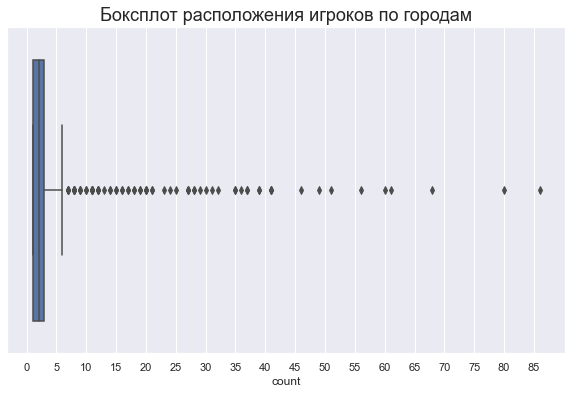

In [59]:
fig, ax = plt.subplots(figsize = (10,6))

ax = sns.boxplot(x='count', data=city_df, orient='h')
ax.xaxis.set_ticks(np.arange(0, 90, 5))

plt.title('Боксплот расположения игроков по городам', fontsize=18)
plt.show()

Заметно, что не наблюдается больших скоплений игроков в одном городе.

В городе с самым большим числом игроков живет всего 86 человек, что составляет только 2.5% от всех игроков.

В большинстве же городов живет не более ~3 человек.

In [60]:
print('Среднее число игроков в одном городе: {:.2f}'.format(city_df['count'].mean()))
print('Медианное число игроков в одном городе: {:.2f}'.format(city_df['count'].median()))

Среднее число игроков в одном городе: 3.78
Медианное число игроков в одном городе: 2.00


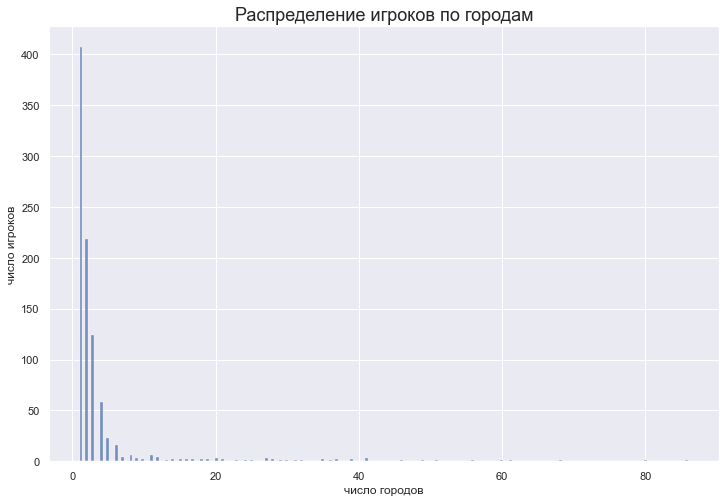

In [61]:
sns.histplot(data=city_df, x='count')
plt.title('Распределение игроков по городам', fontsize=18)
plt.xlabel('число городов')
plt.ylabel('число игроков')

plt.show()

Судя по данным игроки сильно "размазаны" по всей стране.

### Какой процент доходов содержит информацию о городе юзера

Сначала удостоверюсь, что у всех логов выставлена валюта USD.

In [62]:
df.currency.value_counts()

USD    860065
Name: currency, dtype: int64

Все верно. Теперь можно подсчитать суммарный доход с показов.

In [63]:
print('Суммарный доход с показа всей рекламных объявлений составляет: {:.2f}$'.format(df.revenue.sum()))

Суммарный доход с показа всей рекламных объявлений составляет: 2390.73$


In [64]:
revenue_without_city = df.loc[df['city'].isna()]['revenue'].sum()

revenue_with_city = df.loc[~df['city'].isna()]['revenue'].sum()

# проверка, что суммы сходятся
total_revenue = revenue_without_city+revenue_with_city

print('Доход с объявлений с определенным городом юзера: {:.2f}$'.format(revenue_with_city))
print('Доход с объявлений где отсутствует информация о городе юзера: {:.2f}$'.format(revenue_without_city))
print()
print('Суммарный доход с показа всей рекламных объявлений составляет: {:.2f}$'.format(total_revenue))

Доход с объявлений с определенным городом юзера: 1519.95$
Доход с объявлений где отсутствует информация о городе юзера: 870.78$

Суммарный доход с показа всей рекламных объявлений составляет: 2390.73$


#### Вывод

In [65]:
print('{:.2%} процентов дохода содержат информацию о городе юзера.'.format(revenue_with_city/total_revenue))

print('{:.2%} процентов дохода не содержат информацию о городе юзера.'.format(revenue_without_city/total_revenue))

63.58% процентов дохода содержат информацию о городе юзера.
36.42% процентов дохода не содержат информацию о городе юзера.


### Данные из JSON 

В этой секции я поверхностно ознакомлюсь с данными из JSON-ов.

#### ad_type и placement

In [67]:
df.ad_type.value_counts()

banner    815973
int        37610
rv          6482
Name: ad_type, dtype: int64

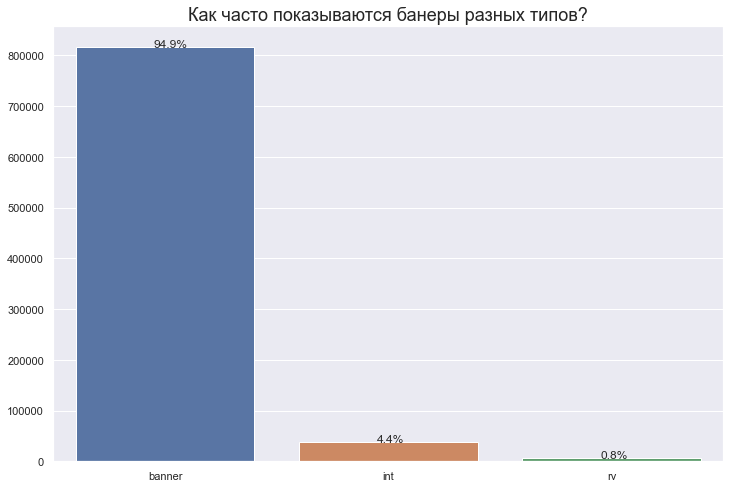

In [68]:
ax=sns.barplot(x=df.ad_type.value_counts().index, y=df.ad_type.value_counts())
plt.title('Как часто показываются банеры разных типов?', fontsize=18)
plt.ylabel('')
plt.xlabel('')

add_percentage(ax, df.ad_type.value_counts(normalize=True))

Показы банеров составляют ~95% всех показов

In [69]:
df.placement.value_counts()

                             815973
next_level                    30576
replay                         5592
lose_offer_attempt             4183
double_coins                   1716
lose_offer_attempt_int          829
game_repeating_reward           583
double_coins_int                497
game_repeating_reward_int       116
Name: placement, dtype: int64

In [70]:
df.loc[df['ad_type']=='banner']['placement'].value_counts()

    815973
Name: placement, dtype: int64

У баннеров отсутствует информация о том, когда и где был показ рекламы

В описании к данным упоминались время и место показа баннера — горизонтальный баннер, висит внизу экрана пока юзер играет.

#### revenue

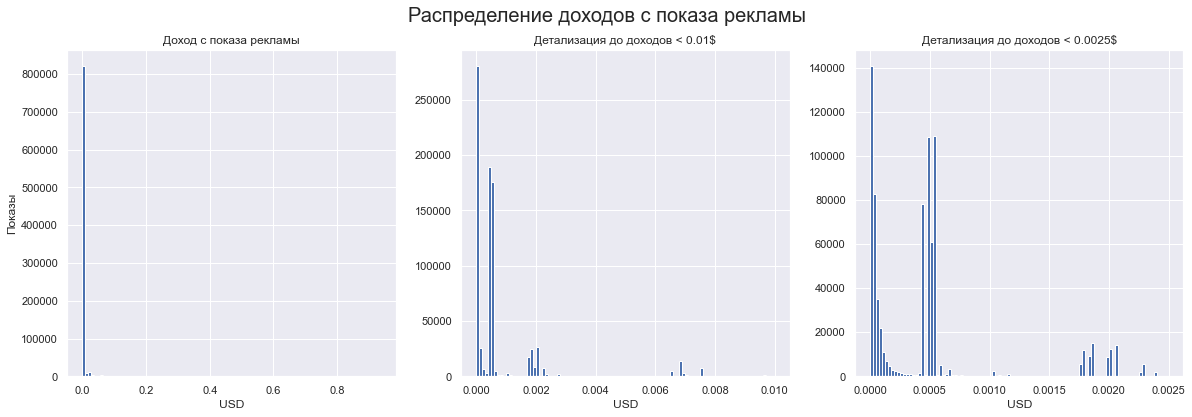

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))
axs[0].hist(x=df.revenue, bins=100)
axs[0].set_title('Доход с показа рекламы')
axs[0].set_xlabel('USD')
axs[0].set_ylabel('Показы')

axs[1].hist(x=df.revenue.loc[df.revenue <0.01], bins=100)
axs[1].set_title('Детализация до доходов < 0.01$')
axs[1].set_xlabel('USD')

axs[2].hist(x=df.revenue.loc[df.revenue <0.0025], bins=100)
axs[2].set_title('Детализация до доходов < 0.0025$')
axs[2].set_xlabel('USD')

fig.suptitle('Распределение доходов с показа рекламы', fontsize=20)

plt.show()

Большая часть объявлений приносит доходы менее 0.0005$ с показа.

Вероятнее всего реклама разных типов приносит разный доход. Попробую это проверить.

In [72]:
ad_type_revenue_groupby = df.groupby('ad_type')['revenue'].agg(['mean', 'median', 'sum'])
ad_type_revenue_groupby

,mean,median,sum
ad_type,,,
banner,0.000744,0.000494,607.178931
int,0.036211,0.021399,1361.888664
rv,0.065051,0.031469,421.661652


Как и ожидалось, у разных типов рекламы разный средний доход.

Для баннеров он равен — 0.000744 USD\
Для полноэкранной рекламы — 0.036211 USD\
Для видео — 0.065051 USD

При этом большую часть прибыли достаточно неожиданно приносит полноэкранная реклама, несмотря на то, что ее показы составляют только 4.4% от всех показов.

Изображу это на графике ниже.

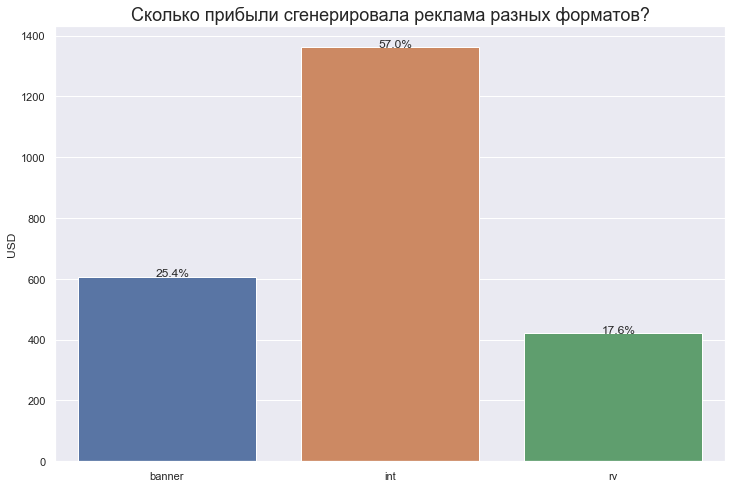

In [73]:
ax=sns.barplot(x='ad_type', y='sum', data=ad_type_revenue_groupby.reset_index())
plt.title('Сколько прибыли сгенерировала реклама разных форматов?', fontsize=18)
plt.ylabel('USD')
plt.xlabel('')

add_percentage(ax, ad_type_revenue_groupby['sum'] / ad_type_revenue_groupby['sum'].sum())

Остальные столбцы из JSON-а для этого исследования мне вероятнее всего не потребуются.

Перехожу к исследованию бизнес задачи.

# Исследование бизнес задачи

Первичный анализ датасета завершен.

В ходе анализа удалось глубже понять данные и сделать на их основе выводы.\
Теперь же я перехожу к основным вопросам исследования.

Повторю, на какие вопросы требуется дать ответы:

1. Для каждого формата рекламы:
    - построить распределение средних eCPM-ов юзеров
    - отобразить средние eCPM-ы по городам, версиям ОС
    - отобразить суммарные доходы по городам, версиям ОС
2. Учесть статистическую значимость для п.1b. Привести решение и описать его.
3. Описать наблюдения и вывод по исследованию.

Дополнительные задачи:\
Исследовать:
- Какой процент доходов содержит информацию о городе юзера — Выполнено
- Зависит ли eCPM от времени дня

## Изучение разных форматов рекламы и их eCPM

Прежде чем приступить к задаче мне нужно рассчитать eCPM-ы для юзеров.

$$eCPM = \frac{Total Ad Earnings} {Impressions} * 1000$$

### Исследование баннеров

#### Распределение средних eCPM-ов юзеров.

Для рассчета среднего eCPM-а юзера мне нужно просуммировать весь revenue с пользовалеля за указанный период, поделить на число показов рекламы и умножить на 1000.

Получившаяся метрика будет eCPM-ом этого конкретного юзера

In [76]:
# filter banners only
banner_df = df.loc[df.ad_type=='banner']

In [77]:
# group by unique users
banner_users_df = banner_df.groupby('profile_id')['revenue'].agg(['sum', 'count']).reset_index()

In [78]:
# device total revenue by the number of adds. muplitply by 1000 to get the metric

banner_users_df['eCPM'] = banner_users_df['sum'] / banner_users_df['count'] * 1000

In [79]:
banner_users_df.head()

,profile_id,sum,count,eCPM
0,JL00qCZH1HV,0.041391,13,3.183940
1,JL015rw9vmN,0.477067,411,1.160748
2,JL01aCdFTJy,0.028124,38,0.740097
3,JL04ODuw9UP,0.017058,80,0.213227
4,JL06OWhBYxn,0.006086,13,0.468146


In [80]:
def get_mean_median(df, column='eCPM'):
    mean = df[column].mean()
    median = df[column].median()
    
    return(mean, median)

In [81]:
def get_outliers_threshold(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3-Q1

    outlier_threshold = Q3+1.5*IQR
    print('Средний eCPM лежащий за пределами Q3 + 1.5xIQR должен быть больше или равен {:.2f}$'.format(outlier_threshold))
    
    return(outlier_threshold)

In [82]:
def build_boxplot(df, title, mean=False, median=False, x='eCPM', ticks=False):
    fig, ax = plt.subplots(figsize = (10,6))

    ax = sns.boxplot(x=x, data=df, orient='h')
    
    if median is not False: 
        ax.axvline(median, color='r', linestyle='--', label="Median eCPM = {:.2f} USD".format(median))
    if mean is not False:
        ax.axvline(mean, color='g', linestyle='--', label="Mean eCPM = {:.2f} USD".format(mean))
    
    if ticks is not False:
        ax.xaxis.set_ticks(ticks)


    if mean is not False or median is not False:
        plt.legend(fontsize='medium')
        
    plt.title(title, fontsize=18)
    plt.show()

In [83]:
ecpm_mean, ecpm_median = get_mean_median(banner_users_df)

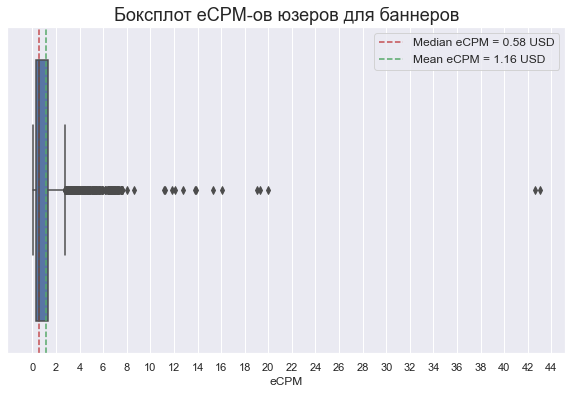

In [84]:
build_boxplot(banner_users_df, 'Боксплот eCPM-ов юзеров для баннеров', mean=ecpm_mean, median=ecpm_median, ticks=np.arange(0, 46, 2))

В данных есть выбросы — пользователи с очень высоким eCPM.

Есть гипотеза, что это игроки с низким числом просмотров рекламы, которые часто по ней переходят и совершают целевое действие. То есть это могут быть новые игроки, которые сразу начали нажимать на рекламу.

Чтобы проверить это предположение я сравню среднее число показов рекламы у людей с средним eCPM больше Q3 + 1.5IQR (выходящие за границы "усов" боксплота) с остальными пользователями.

In [85]:
outlier_threshold = get_outliers_threshold(banner_users_df, 'eCPM')

Средний eCPM лежащий за пределами Q3 + 1.5xIQR должен быть больше или равен 2.76$


In [86]:
banner_users_df.loc[banner_users_df['eCPM']>=outlier_threshold]['count'].mean()

143.0065789473684

In [87]:
banner_users_df.loc[banner_users_df['eCPM']<outlier_threshold]['count'].mean()

241.104556803995

In [88]:
mean_outliers_count = banner_users_df.loc[banner_users_df['eCPM']>=outlier_threshold]['count'].mean()
mean_rest_count = banner_users_df.loc[banner_users_df['eCPM']<outlier_threshold]['count'].mean()
mean_all_count = banner_users_df['count'].mean()

print('Среднее число просмотров баннеров у аутлаеров: {:.2f}'.format(mean_outliers_count))
print('Среднее число просмотров баннеров у остальных людей: {:.2f}'.format(mean_rest_count))
print('Среднее число просмотров баннеров у всех людей: {:.2f}'.format(mean_all_count))

Среднее число просмотров баннеров у аутлаеров: 143.01
Среднее число просмотров баннеров у остальных людей: 241.10
Среднее число просмотров баннеров у всех людей: 232.60


Разница есть, однако не такая большая, чтобы отбросить аутлаеры для анализа.

In [89]:
def build_hist(x, suptitle, xlabel='USD', title='', mean=False, median=False, bins=100, alpha=0.7):
    fig, axs = plt.subplots(1, 1, figsize=(10,6))

    axs.hist(x=x, bins=bins, alpha = alpha)
    
    if mean is not False:
        axs.axvline(mean, color='g', linestyle='--', linewidth=3, label="Mean = {:.2f} USD".format(mean))
    if median is not False:
        axs.axvline(median, color='r', linestyle='--', linewidth=3, label="Median = {:.2f} USD".format(median))

    axs.set_title(title)
    axs.set_xlabel(xlabel)

    fig.suptitle(suptitle, fontsize=18)
    
    if mean is not False or median is not False:
        plt.legend(fontsize='medium')

    plt.show()

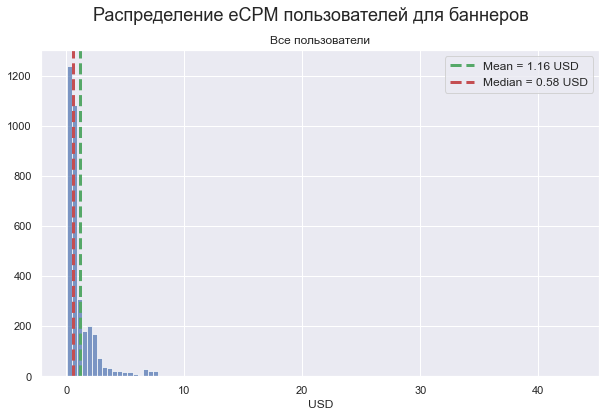

In [90]:
build_hist(x=banner_users_df.eCPM, 
           suptitle='Распределение eCPM пользователей для баннеров', 
           title='Все пользователи',
           mean=ecpm_mean,
           median=ecpm_median)

Аутлаеры сместили в свою сторону график. Детализирую график до пользователей с eCPM < outlier_threshold (2.76$)

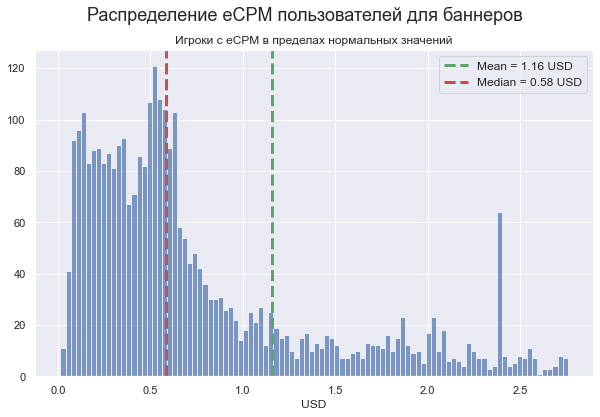

In [91]:
build_hist(x=banner_users_df.eCPM.loc[banner_users_df.eCPM<outlier_threshold], 
           suptitle='Распределение eCPM пользователей для баннеров', 
           title='Игроки с eCPM в пределах нормальных значений',
           mean=ecpm_mean,
           median=ecpm_median)

По графикам выше заметно, что у некоторых игроков eCPM значительно выше чем у большинства.\
В то время как средний eCPM составляет 1.16 USD, для некоторых игроков он выше 5 USD, есть даже пара человек с eCPM ~43 USD

#### Средние eCPM по городам

Сгруппирую данные по городам

In [92]:
banner_city_df = banner_df.groupby('city')['revenue'].agg(['sum', 'count'])

In [93]:
# device total revenue by the number of adds. muplitply by 1000 to get the metric
banner_city_df['eCPM'] = banner_city_df['sum'] / banner_city_df['count'] * 1000

banner_city_df.head()

,sum,count,eCPM
city,,,
Aberdeen,0.030866,96,0.321518
Abilene,0.043299,46,0.941283
Addison,0.000142,1,0.142235
Afton,0.110404,364,0.303306
Akron,0.131979,339,0.389318


In [94]:
ecpm_mean, ecpm_median = get_mean_median(banner_city_df)

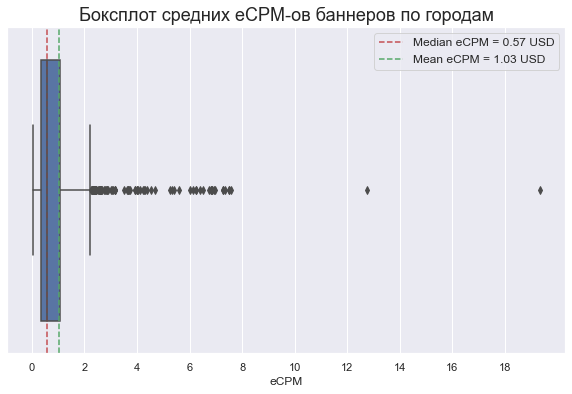

In [95]:
build_boxplot(banner_city_df, 'Боксплот средних eCPM-ов баннеров по городам', mean=ecpm_mean, median=ecpm_median, ticks=np.arange(0, 20, 2))

Данные смещены вправо — из-за аутлаеров среднее вдвое больше медианы.

Стоит проверить, какие города смещают среднее так сильно — из-за того, что в некоторых городах живет всего по одному человеку, данные сильно подвержены выбросам.

In [96]:
outlier_threshold = get_outliers_threshold(banner_city_df, 'eCPM')

Средний eCPM лежащий за пределами Q3 + 1.5xIQR должен быть больше или равен 2.21$


In [97]:
count_mean, count_median = get_mean_median(banner_city_df, column='count')

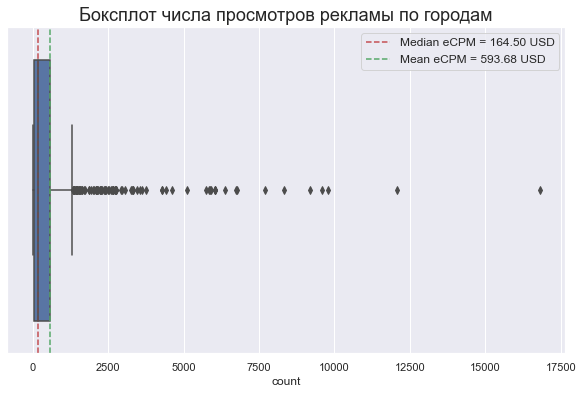

In [98]:
build_boxplot(banner_city_df,
              'Боксплот числа просмотров рекламы по городам',
              mean=count_mean,
              median=count_median, 
              x='count')

Видно, что большинство городов имеют низкое число просмотров — медиана лежит в районе 160 просмотров на город.

Это примерно совпадает с ранными наблюдением, что один человек в среднем имеет порядка 232 просмотров рекламы.

Чтобы изучить зависимость средних eCPM-ов игроков от городов мне нужно будет отбросить города с низким числом просмотров.

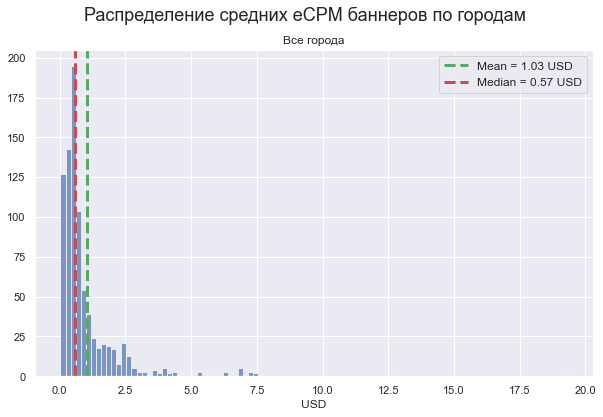

In [99]:
build_hist(x=banner_city_df.eCPM, 
           suptitle='Распределение средних eCPM баннеров по городам', 
           title='Все города',
           mean=ecpm_mean,
           median=ecpm_median)

In [100]:
banner_city_df.sort_values(by='count', ascending=False)

,sum,count,eCPM
city,,,
New York,12.708617,16801,0.756420
Minneapolis,7.629354,12066,0.632302
Springfield,4.930910,9769,0.504751
Houston,8.664916,9578,0.904669
Charlotte,6.888516,9196,0.749077
...,...,...,...
Fremont,0.000156,1,0.156188
Kingston,0.000087,1,0.087037
Indio,0.000090,1,0.089887


Отберу топ 20 городов с самым большим числом просмотров и изучу их отдельно

In [101]:
top20_banner_cities = banner_city_df.sort_values(by='count', ascending=False)[:20]

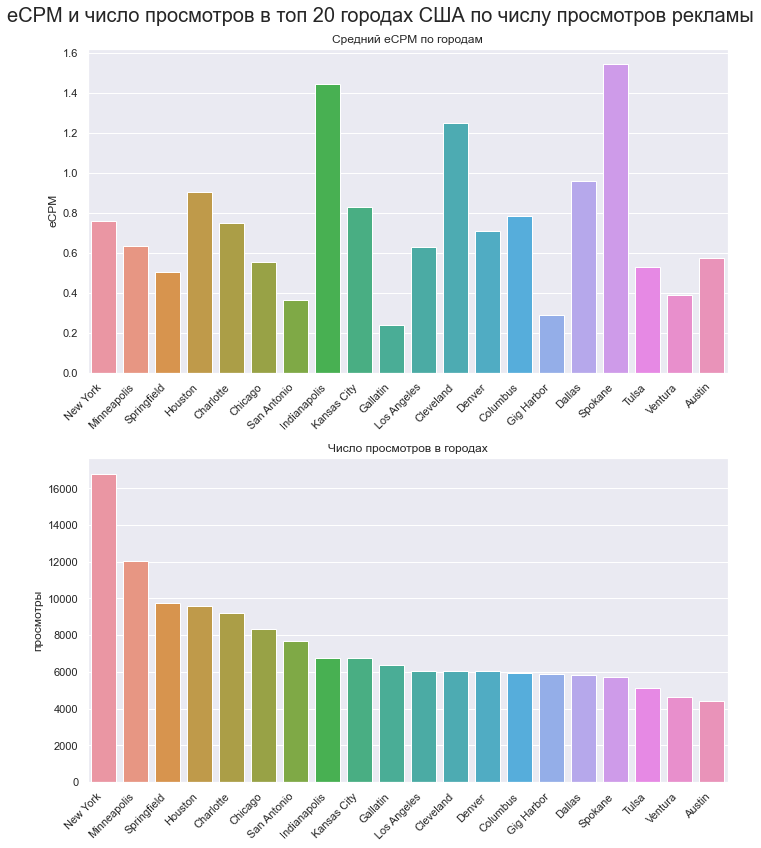

In [102]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

sns.barplot(x=top20_banner_cities.index, y='eCPM', data=top20_banner_cities, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[0].set_title('Средний eCPM по городам')
axs[0].set_xlabel('')

sns.barplot(x=top20_banner_cities.index, y='count', data=top20_banner_cities, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[1].set_title('Число просмотров в городах')
axs[1].set_ylabel('просмотры')
axs[1].set_xlabel('')

fig.suptitle('eCPM и число просмотров в топ 20 городах США по числу просмотров рекламы', fontsize=20)
fig.tight_layout()
plt.show()

Чтобы оценить, есть ли взаимосвязь между числом просмотров и средним eCPM я воспользуюсь коэффициентном корреляции Пирсона.

Гипотеза — в городах где пользователи активнее смотрят рекламу eCPM будет выше.

In [103]:
def pearson_corr(data1, data2, alpha=0.05):
    stat, p = pearsonr(data1, data2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('Два параметра вероятнее всего независимы')
    else:
        print('Два параметра вероятнее всего зависимы')

In [104]:
pearson_corr(top20_banner_cities['count'], top20_banner_cities['eCPM'])

stat=-0.020, p=0.934
Два параметра вероятнее всего независимы


Также я хочу попарно сравнить друг с другом города из топ 20 при помощи теста Тьюки (https://en.wikipedia.org/wiki/Tukey%27s_range_test)

С помощью него я планирую проверить наблюдения, которые можно сделать по графикам.

Сравнивать я буду колонки revenue, потому что на их основании производится подсчет eCPM.

In [105]:
def tukey(df, endog_column, groups_column, alpha=0.5):
    test = pairwise_tukeyhsd(endog=df[endog_column],
                              groups=df[groups_column],
                              alpha=0.05)
    #display results
    return test.summary()

In [106]:
# отобрать только топ 20 городов
top20_city_banner_df = banner_df.loc[banner_df['city'].isin(top20_banner_cities.index)]

In [107]:
top20_city_banner_tukey = tukey(top20_city_banner_df, 'revenue', 'city')

# чтобы увидеть результаты теста тьюки, раскомментируйте строку ниже

#top20_city_banner_tukey

По графикам выше и проверке при помощи коэффициента корреляции Пирсона становится видно, что нет прямой зависимости между числом просмотров и средним eCPM для рекламы баннеров.

Несмотря на то, что Нью-Йорк лидирует по числу просмотров баннеров, eCPM баннеров в городе довольно средний — 0.75, что выше чем медиана, но явно проигрывает Индианаполису с eCPM > 1.4 $.

При помощи критерия Тьюки удалось подтвердить стат-значимость результатов для топ 3 городов — то есть города Спокан, Индаианаполис и Кливленд вероятнее всего действительно расположено в таком порядке по среднему eCPM.

#### Средние eCPM по версиям ОС

In [108]:
banner_os_df = banner_df.groupby('os_version')['revenue'].agg(['sum', 'count'])

In [109]:
# os total revenue by the number of adds. muplitply by 1000 to get the metric
banner_os_df['eCPM'] = banner_os_df['sum'] / banner_os_df['count'] * 1000

banner_os_df.sort_values(by='eCPM', ascending=False, inplace=True)
banner_os_df

,sum,count,eCPM
os_version,,,
12,363.488994,387982,0.936871
11,116.293239,196185,0.592773
10,85.002788,143762,0.591274
9,34.820249,63361,0.549553
lower,7.573662,24683,0.306837


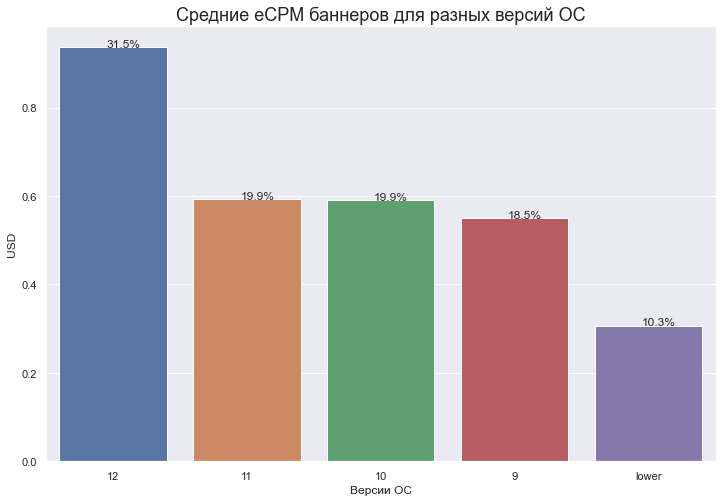

In [110]:
ax = sns.barplot(x=banner_os_df.index, y='eCPM', data=banner_os_df)

plt.ylabel('USD')
plt.xlabel('Версии ОС')
plt.title('Средние eCPM баннеров для разных версий ОС', fontsize=18)

add_percentage(ax, banner_os_df['eCPM'] / banner_os_df['eCPM'].sum())

In [111]:
pearson_corr(banner_os_df['count'], banner_os_df['eCPM'])

stat=0.947, p=0.014
Два параметра вероятнее всего зависимы


In [112]:
tukey(banner_df, 'revenue', 'os_version')

group1,group2,meandiff,p-adj,lower,upper,reject
10,11,0.0,0.998,-0.0,0.0,False
10,12,0.0003,0.0,0.0003,0.0004,True
10,9,-0.0,0.0,-0.0001,-0.0,True
10,lower,-0.0003,0.0,-0.0003,-0.0003,True
11,12,0.0003,0.0,0.0003,0.0004,True
11,9,-0.0,0.0,-0.0001,-0.0,True
11,lower,-0.0003,0.0,-0.0003,-0.0003,True
12,9,-0.0004,0.0,-0.0004,-0.0004,True
12,lower,-0.0006,0.0,-0.0007,-0.0006,True
9,lower,-0.0002,0.0,-0.0003,-0.0002,True


Видно, что лидирует 12 версия ОС, имея средний eCPM 0.94$.

Корреляций Пирсона также сообщает, что есть связь между числом просмотров рекламы и средним eCPM.\
Критерий Тьюки подтверждает эти наблюдения — статистически значимой разницы нет только между 10 и 11 версиями ОС, что также видно и по графику.

Можно заключить, что средний eCPM 12 версии статистически значимо выше чем у остальных версий ОС.

eCPM по остальным популярным версиям примерно равен — ~0.59$.

eCPM на девайсах с версией ОС ниже девятой (менее 5% от всех девайсов) самый низкий — ~0.31$

#### Суммарные доходы по городам и версиям ОС

In [113]:
sum_mean, sum_median = get_mean_median(banner_city_df, column='sum')

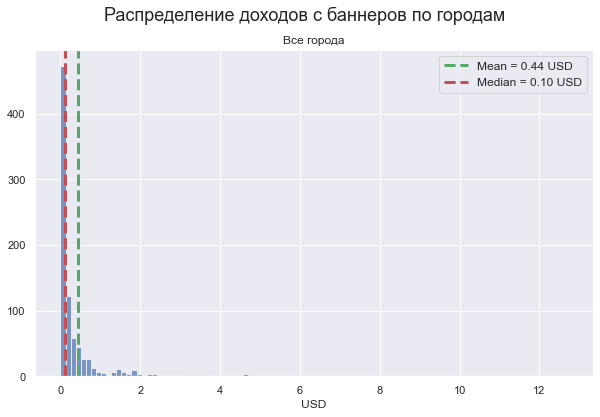

In [114]:
build_hist(x=banner_city_df['sum'], 
           suptitle='Распределение доходов с баннеров по городам', 
           title='Все города',
           mean=sum_mean,
           median=sum_median)

В среднем один город за указанный период принес доход 0.1 USD.

Это логично, ведь в датасете 920 городов в большинстве из которых живет менее десяти пользователей.

Псотрою график для двадцати самых активных городов.

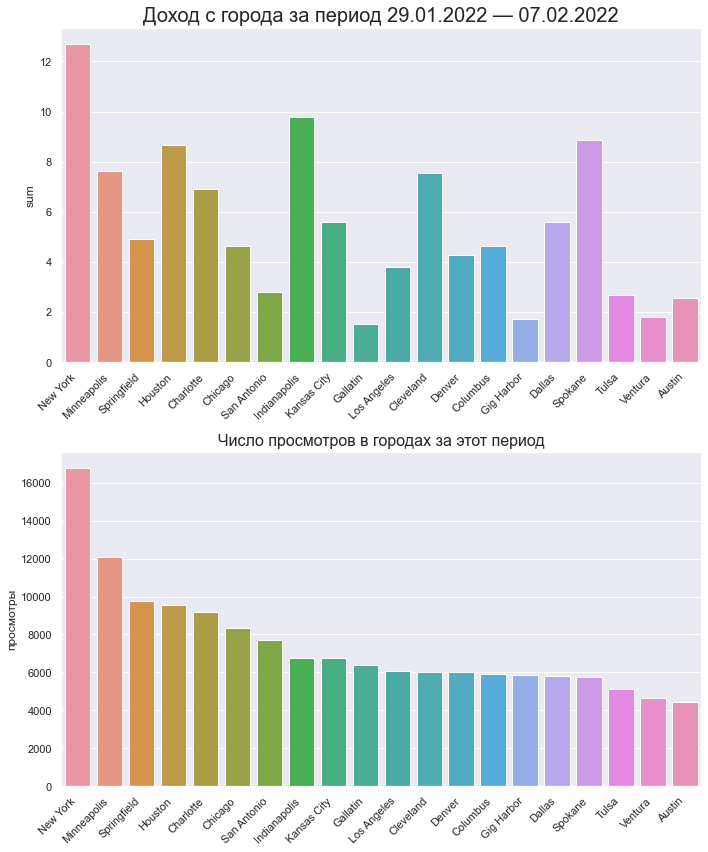

In [115]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

sns.barplot(x=top20_banner_cities.index, y='sum', data=top20_banner_cities, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[0].set_title('Доход с города за период 29.01.2022 — 07.02.2022', size=20)
axs[0].set_xlabel('')

sns.barplot(x=top20_banner_cities.index, y='count', data=top20_banner_cities, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[1].set_title('Число просмотров в городах за этот период', size=16)
axs[1].set_ylabel('просмотры')
axs[1].set_xlabel('')

fig.tight_layout()
plt.show()

Наблюдение на графике выше соотносится с наблюдением в предыдущем шаге — если eCPM с показа баннера высокий, то даже при равном числе просмотров доход у города будет выше.

Хорошие примеры — города Индианаполис и Спокан, которые при не самом большом числе просмотров имеют топ 2 и топ 3 по суммарным доходам.

Лидирует же в списке Нью-Йорк, главным образом из-за самого большого числа просмотров.

Посмотрою аналогичный график для доходов по разным версиям ОС.

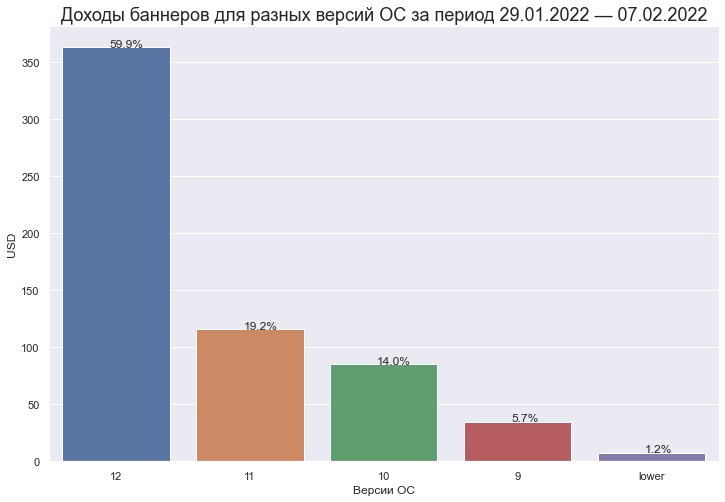

In [116]:
ax = sns.barplot(x=banner_os_df.index, y='sum', data=banner_os_df)

plt.ylabel('USD')
plt.xlabel('Версии ОС')
plt.title('Доходы баннеров для разных версий ОС за период 29.01.2022 — 07.02.2022', fontsize=18)

add_percentage(ax, banner_os_df['sum'] / banner_os_df['sum'].sum())

Большую часть прибыли сгенерировали показы баннеров на двенадцатой версии ОС — 60% всех доходов.

Версии ниже девятой суммарно заработали только около 1% от всех доходов от показов баннеров.

Это только больше усиливает уверенность в том, что при необходимости можно прекращать поддержку этих устройств.

### Исследование полноэкранной рекламы

In [117]:
int_df = df.loc[df.ad_type=='int']

# group by unique users
int_users_df = int_df.groupby('profile_id')['revenue'].agg(['sum', 'count']).reset_index()

int_users_df['eCPM'] = int_users_df['sum'] / int_users_df['count'] * 1000
int_users_df.head()

,profile_id,sum,count,eCPM
0,JL015rw9vmN,0.395698,18,21.983199
1,JL01aCdFTJy,0.011966,1,11.965651
2,JL04ODuw9UP,0.046320,2,23.160000
3,JL06b4k4ygp,0.014655,2,7.327454
4,JL06eD8uPpv,0.089640,2,44.820000


#### Распределение средних eCPM-ов юзеров.

In [118]:
ecpm_mean, ecpm_median = get_mean_median(int_users_df)

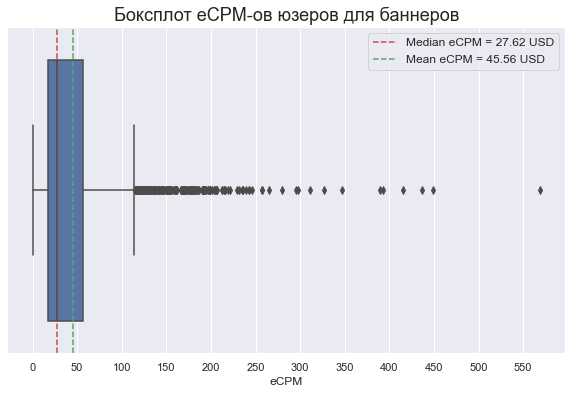

In [119]:
build_boxplot(int_users_df, 
              'Боксплот eCPM-ов юзеров для баннеров', 
              mean=ecpm_mean, 
              median=ecpm_median,
              ticks=np.arange(0, 600, 50))

Сразу видно, что eCPM с показа полноэкранной рекламы значительно выше чем у баннеров.

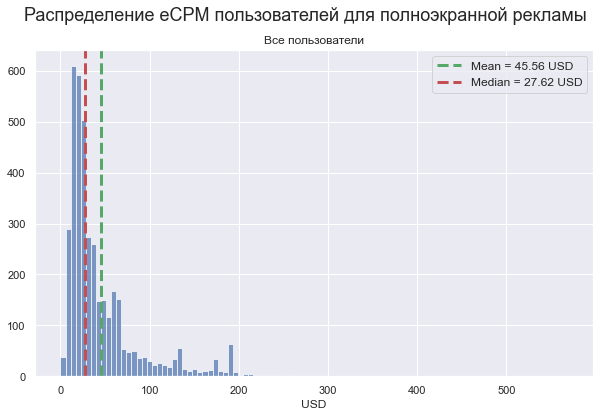

In [120]:
build_hist(x=int_users_df.eCPM, 
           suptitle='Распределение eCPM пользователей для полноэкранной рекламы', 
           title='Все пользователи',
           mean=ecpm_mean,
           median=ecpm_median)

In [121]:
outlier_threshold = get_outliers_threshold(int_users_df, 'eCPM')

Средний eCPM лежащий за пределами Q3 + 1.5xIQR должен быть больше или равен 114.56$


Детализирую график до пользователей с eCPM < 200$. 

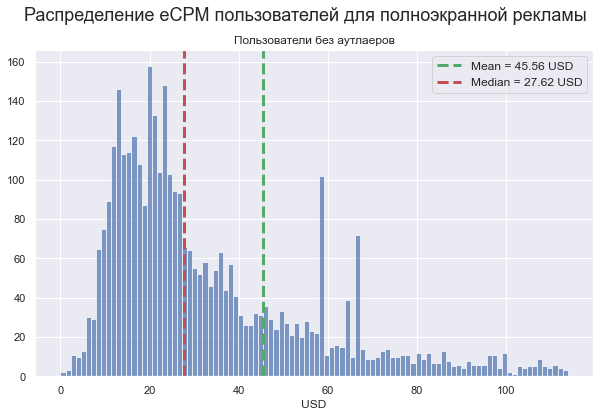

In [122]:
build_hist(x=int_users_df.loc[int_users_df.eCPM<outlier_threshold]['eCPM'], 
           suptitle='Распределение eCPM пользователей для полноэкранной рекламы', 
           title='Пользователи без аутлаеров',
           mean=ecpm_mean,
           median=ecpm_median)

Также как и с показом баннеров, некоторые пользователи имеют очень высокий eCPM — более 114$.

По графикам выше становится понятно, почему полноэкранная реклама принесла 57% доходов, тогда как составляет лишь 4.4% от всех показов.

Главной причиной является очень высокий eCPM в сравнении с баннерами (средний eCPM на пользователя которых равен 1.16$).

In [123]:
print('средний eCPM на пользователя выше чем у баннеров в {:.2f} раз.'.format(45.56/1.16))

средний eCPM на пользователя выше чем у баннеров в 39.28 раз.


#### Средние eCPM по городам

In [124]:
int_city_df = int_df.groupby('city')['revenue'].agg(['sum', 'count'])

In [125]:
int_city_df['eCPM'] = int_city_df['sum'] / int_city_df['count'] * 1000

int_city_df.head()

,sum,count,eCPM
city,,,
Aberdeen,0.081500,6,13.583285
Abilene,0.402410,8,50.301282
Afton,0.727219,25,29.088757
Akron,1.680295,26,64.626718
Alameda,0.020145,1,20.145481


In [126]:
ecpm_mean, ecpm_median = get_mean_median(int_city_df)

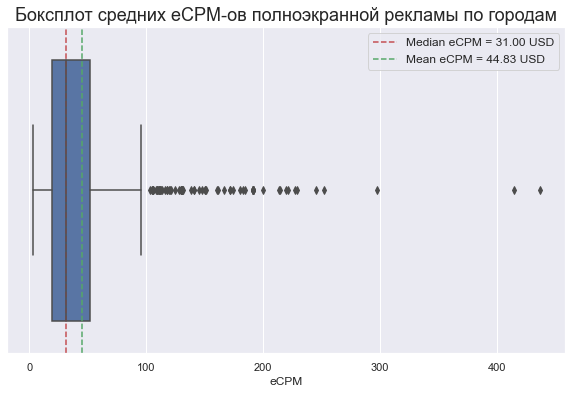

In [127]:
build_boxplot(int_city_df, 
              'Боксплот средних eCPM-ов полноэкранной рекламы по городам', 
              mean=ecpm_mean, 
              median=ecpm_median)

In [128]:
outlier_threshold = get_outliers_threshold(int_city_df, 'eCPM')

Средний eCPM лежащий за пределами Q3 + 1.5xIQR должен быть больше или равен 101.24$


Также как и с баннерами в данных присутствует города на которые приходится всего по одному просмотру.

Выведу график eCPM-ов для топ-20 городов.

In [129]:
top20_int_cities = int_city_df.sort_values(by='count', ascending=False)[:20]
top20_int_cities

,sum,count,eCPM
city,,,
Minneapolis,17.286339,718,24.075681
New York,25.674272,652,39.377718
Charlotte,14.940739,497,30.061848
Houston,14.497606,462,31.380099
Springfield,7.426912,363,20.459813
Chicago,8.541078,347,24.614058
Cleveland,18.112861,344,52.653665
Indianapolis,21.534431,317,67.931958
Dallas,10.198381,307,33.219483


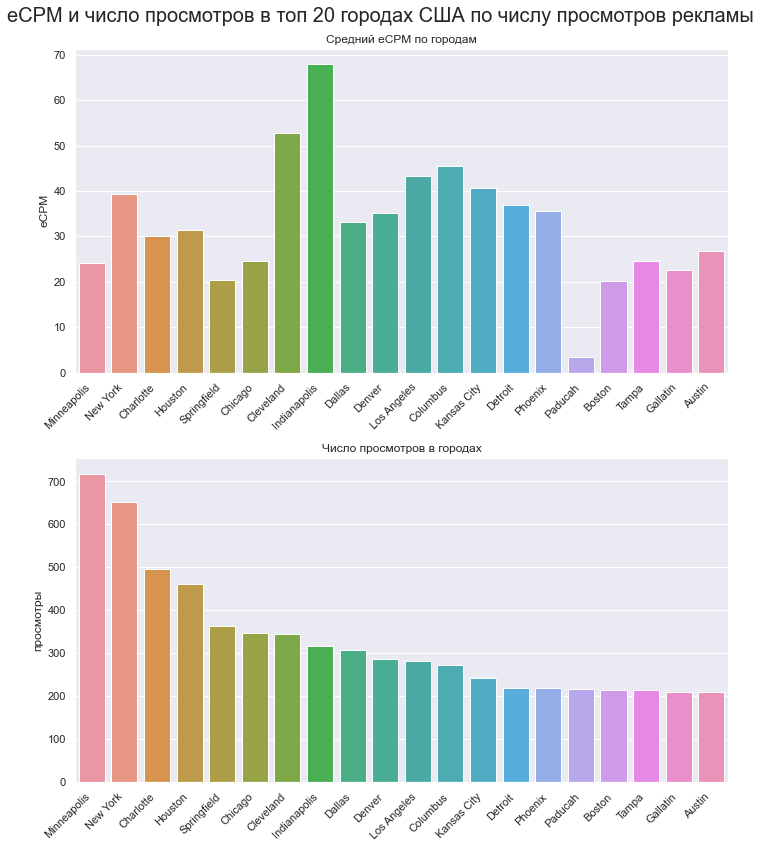

In [130]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

sns.barplot(x=top20_int_cities.index, y='eCPM', data=top20_int_cities, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[0].set_title('Средний eCPM по городам')
axs[0].set_xlabel('')

sns.barplot(x=top20_int_cities.index, y='count', data=top20_int_cities, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[1].set_title('Число просмотров в городах')
axs[1].set_ylabel('просмотры')
axs[1].set_xlabel('')

fig.suptitle('eCPM и число просмотров в топ 20 городах США по числу просмотров рекламы', fontsize=20)
fig.tight_layout()
plt.show()

In [131]:
pearson_corr(top20_int_cities['count'], top20_int_cities['eCPM'])

stat=0.058, p=0.808
Два параметра вероятнее всего независимы


In [132]:
# отобрать только топ 20 городов
top20_int_cities_df = int_df.loc[int_df['city'].isin(top20_int_cities.index)]

top20_city_banner_tukey = tukey(top20_int_cities_df, 'revenue', 'city')

# чтобы увидеть результаты теста тьюки, раскомментируйте строку ниже
#top20_city_banner_tukey

Интересное наблюдение — в Нью-Йорке люди активнее смотрят баннеры, а в Миннеаполисе полноэкранную рекламу.

Однако и здесь не похоже, что бы число просмотров коррелировало с eCPM. 

Я могу сделать вывод, что в некоторых городах в принципе реклама стоит дороже, возможно из-за более высокого уровня жизни в этих городах.\
Так, Индианаполис и Кливлэнд снова лидируют по среднему eCPM в этих городах, однако критерий Тьюки дает уверенность только в Индианаполисе.\
Некоторые города могут иметь средний eCPM на уровне с Кливлэндом (Колумбус, Казнас и Лос-Анджелес), так-как не удалось отвергнуть нулевую гипотезу о равенстве средних revenue в этих городах.

#### Средние eCPM по версиям ОС

In [133]:
int_os_df = int_df.groupby('os_version')['revenue'].agg(['sum', 'count'])

# os total revenue by the number of adds. muplitply by 1000 to get the metric
int_os_df['eCPM'] = int_os_df['sum'] / int_os_df['count'] * 1000

int_os_df.sort_values(by='eCPM', ascending=False, inplace=True)
int_os_df

,sum,count,eCPM
os_version,,,
12,704.497187,16619,42.391070
11,363.570629,10862,33.471794
10,191.795052,6144,31.216643
9,78.475755,2906,27.004733
lower,23.550040,1079,21.825802


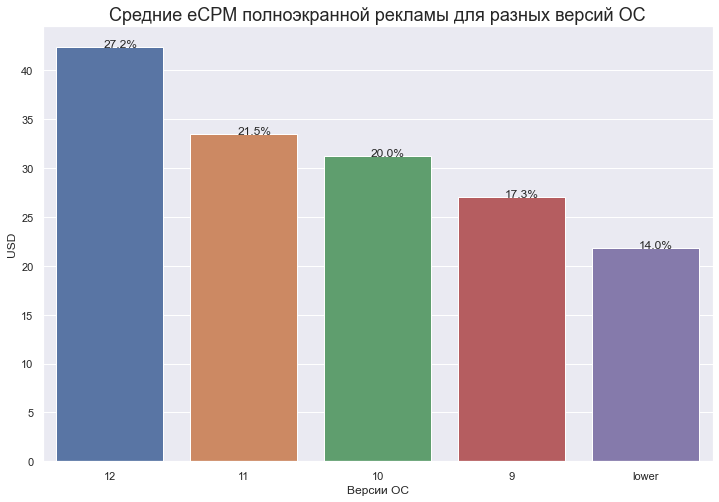

In [134]:
ax = sns.barplot(x=int_os_df.index, y='eCPM', data=int_os_df)

plt.ylabel('USD')
plt.xlabel('Версии ОС')
plt.title('Средние eCPM полноэкранной рекламы для разных версий ОС', fontsize=18)

add_percentage(ax, int_os_df['eCPM'] / int_os_df['eCPM'].sum())

In [135]:
pearson_corr(int_os_df['count'], int_os_df['eCPM'])

stat=0.978, p=0.004
Два параметра вероятнее всего зависимы


In [136]:
tukey(int_df, 'revenue', 'os_version')

group1,group2,meandiff,p-adj,lower,upper,reject
10,11,0.0023,0.0261,0.0002,0.0043,True
10,12,0.0112,-0.0,0.0092,0.0131,True
10,9,-0.0042,0.0009,-0.0071,-0.0013,True
10,lower,-0.0094,0.0,-0.0137,-0.0051,True
11,12,0.0089,-0.0,0.0073,0.0105,True
11,9,-0.0065,0.0,-0.0092,-0.0037,True
11,lower,-0.0116,-0.0,-0.0158,-0.0075,True
12,9,-0.0154,-0.0,-0.018,-0.0128,True
12,lower,-0.0206,-0.0,-0.0247,-0.0165,True
9,lower,-0.0052,0.0202,-0.0098,-0.0005,True


eCPM для полноэкранной рекламы не так значительно отличается между версиясм в сравнении с баннерами.

12 версия снова лидирует, но если с баннерами eCPM был на 12 процентных пункта выше чем у следующей позиции, то здесь разница сильно мягче.

Критерий Тьюки подтверждает стат значимость различий между выручкой с разных версий ОС.

#### Суммарные доходы по городам и версиям ОС

In [137]:
sum_mean, sum_median = get_mean_median(int_city_df, column='sum')

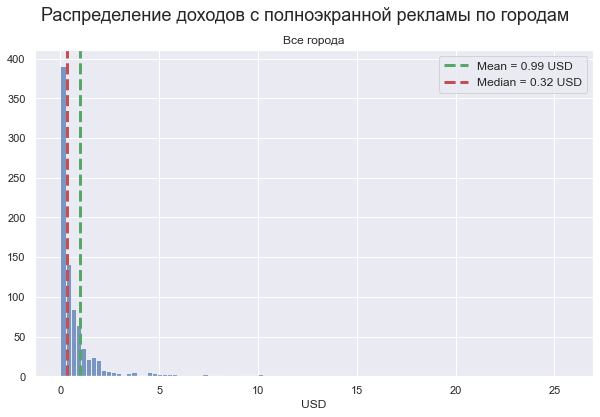

In [138]:
build_hist(x=int_city_df['sum'], 
           suptitle='Распределение доходов с полноэкранной рекламы по городам', 
           title='Все города',
           mean=sum_mean,
           median=sum_median)

В среднем каждый город заработал около 1 USD.

Но из-за наличия больших выбросов, лучше ориентироваться на медианное значение — 0.32 USD.

Построю график для топ 20 городов.

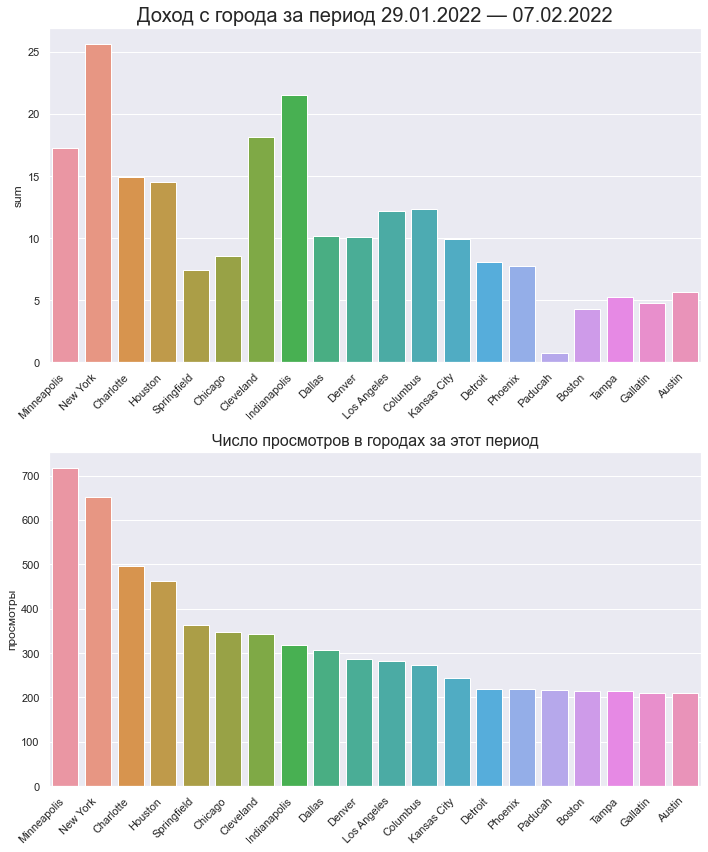

In [139]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

sns.barplot(x=top20_int_cities.index, y='sum', data=top20_int_cities, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[0].set_title('Доход с города за период 29.01.2022 — 07.02.2022', size=20)
axs[0].set_xlabel('')

sns.barplot(x=top20_int_cities.index, y='count', data=top20_int_cities, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[1].set_title('Число просмотров в городах за этот период', size=16)
axs[1].set_ylabel('просмотры')
axs[1].set_xlabel('')

fig.tight_layout()
plt.show()

Топ 1 город по доходам снова Нью-Йорк, топ 2 снова Индианаполис.

Несмотря на то, что в Миннеаполисе больше просмотров полноэкранной рекламы, доход не такой большой как в других городах из-за более низкого eCPM.

Построю аналогичный график для разных версий ОС

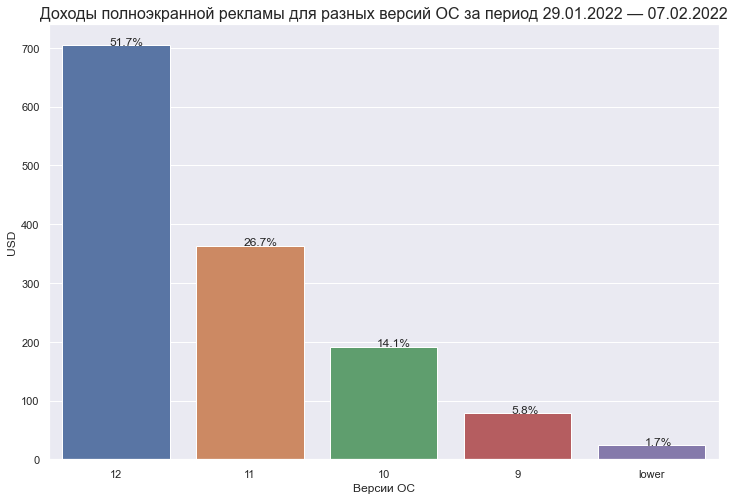

In [140]:
ax = sns.barplot(x=int_os_df.index, y='sum', data=int_os_df)

plt.ylabel('USD')
plt.xlabel('Версии ОС')
plt.title('Доходы полноэкранной рекламы для разных версий ОС за период 29.01.2022 — 07.02.2022', fontsize=16)

add_percentage(ax, int_os_df['sum'] / int_os_df['sum'].sum())

Распределение получилось примерно такое же, как и для баннеров — большую часть дохода принесли девайсы с ОС 12.

Версии ниже 9 — незначительную часть дохода.

### Исследование видео рекламы

In [141]:
rv_df = df.loc[df.ad_type=='rv']

#### Распределение средних eCPM-ов юзеров

In [142]:
# group by unique users
rv_users_df = rv_df.groupby('profile_id')['revenue'].agg(['sum', 'count']).reset_index()

rv_users_df['eCPM'] = rv_users_df['sum'] / rv_users_df['count'] * 1000
rv_users_df.head()

,profile_id,sum,count,eCPM
0,JL04ODuw9UP,0.161280,2,80.640000
1,JL06eD8uPpv,0.211700,1,211.700000
2,JL0GsLmgQqj,0.021516,1,21.516378
3,JL0aZ4tP8jc,0.538381,27,19.940048
4,JL0axMwodcw,0.846800,4,211.700000


In [143]:
ecpm_mean, ecpm_median = get_mean_median(rv_users_df)

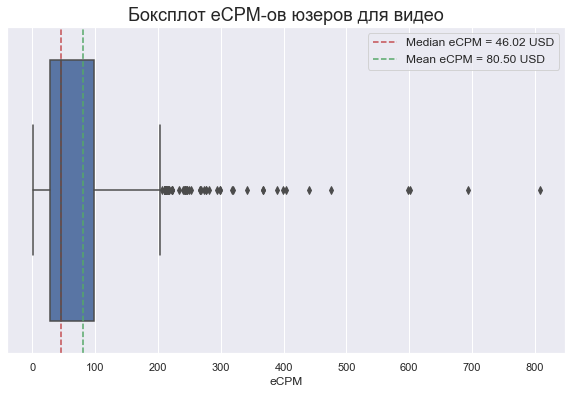

In [144]:
build_boxplot(rv_users_df, 
              'Боксплот eCPM-ов юзеров для видео', 
              mean=ecpm_mean, 
              median=ecpm_median)

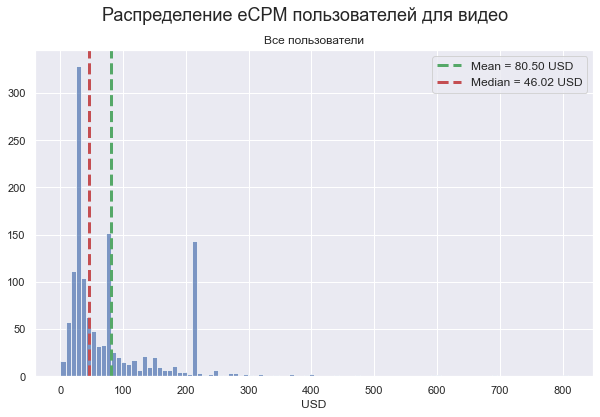

In [145]:
build_hist(x=rv_users_df.eCPM, 
           suptitle='Распределение eCPM пользователей для видео', 
           title='Все пользователи',
           mean=ecpm_mean,
           median=ecpm_median)

Аутлаеры сместили в свою сторону график.\
Детализирую график до пользователей с eCPM < Q3 + 1.5xIQR, то есть находящихся в пределах "усов" боксплота

In [146]:
outlier_threshold = get_outliers_threshold(rv_users_df, 'eCPM')

Средний eCPM лежащий за пределами Q3 + 1.5xIQR должен быть больше или равен 202.81$


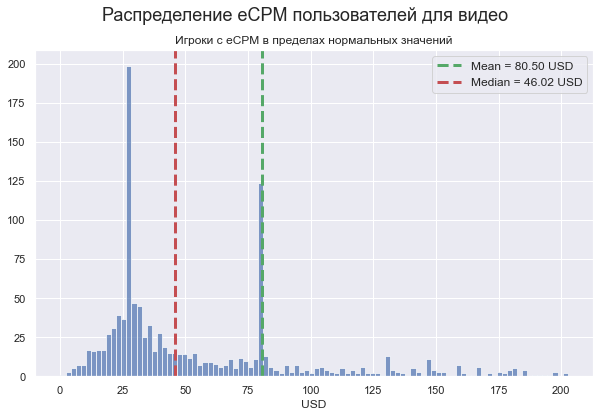

In [147]:
build_hist(x=rv_users_df.eCPM.loc[rv_users_df.eCPM<outlier_threshold], 
           suptitle='Распределение eCPM пользователей для видео', 
           title='Игроки с eCPM в пределах нормальных значений',
           mean=ecpm_mean,
           median=ecpm_median)

Видео ожидаемо является самой дорогой рекламой, медианной eCPM на юзера равен 46.02 USD, что почти вдвое больше полноэкранной рекламы

#### Средние eCPM по городам

In [148]:
rv_city_df = rv_df.groupby('city')['revenue'].agg(['sum', 'count'])

# device total revenue by the number of adds. muplitply by 1000 to get the metric
rv_city_df['eCPM'] = rv_city_df['sum'] / rv_city_df['count'] * 1000

rv_city_df.head()

,sum,count,eCPM
city,,,
Aberdeen,0.021516,1,21.516378
Abilene,0.106986,2,53.492880
Akron,1.656296,9,184.032872
Alameda,0.080640,1,80.640000
Albany,0.162581,2,81.290421


Сразу становится заметно, что есть много городов с очень маленьким числом просмотров.

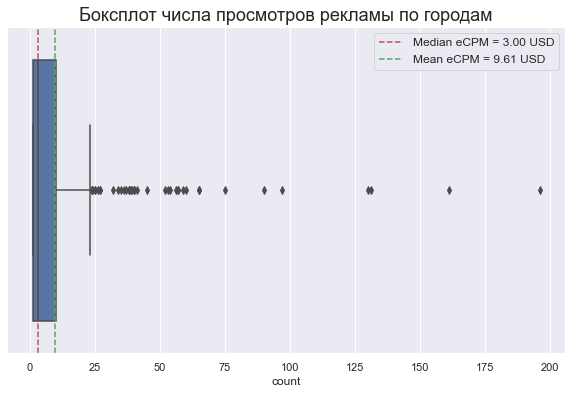

In [149]:
count_mean, count_median = get_mean_median(rv_city_df, column='count')

build_boxplot(rv_city_df,
              'Боксплот числа просмотров рекламы по городам',
              mean=count_mean,
              median=count_median, 
              x='count')

В большинсве городов число просмотров менее 25.\
Отберу топ 20 и посмотрю, сколько просмотров в них.

In [150]:
top20_rv_cities = rv_city_df.sort_values(by='count', ascending=False)[:20]

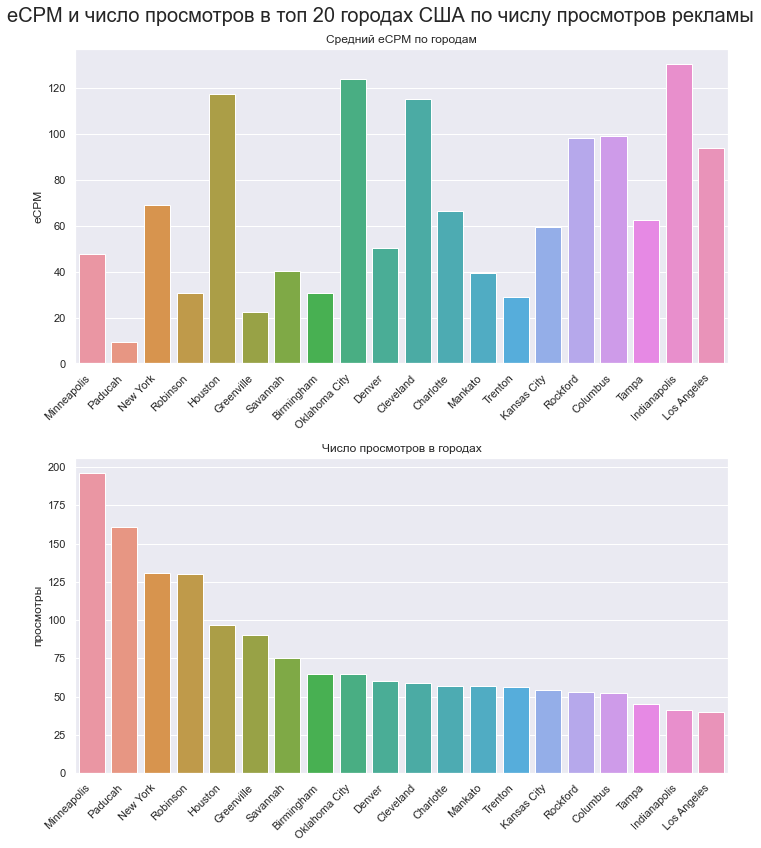

In [151]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

sns.barplot(x=top20_rv_cities.index, y='eCPM', data=top20_rv_cities, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[0].set_title('Средний eCPM по городам')
axs[0].set_xlabel('')

sns.barplot(x=top20_rv_cities.index, y='count', data=top20_rv_cities, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[1].set_title('Число просмотров в городах')
axs[1].set_ylabel('просмотры')
axs[1].set_xlabel('')

fig.suptitle('eCPM и число просмотров в топ 20 городах США по числу просмотров рекламы', fontsize=20)
fig.tight_layout()
plt.show()

In [152]:
pearson_corr(top20_rv_cities['count'], top20_rv_cities['eCPM'])

stat=-0.410, p=0.072
Два параметра вероятнее всего независимы


In [153]:
# отобрать только топ 20 городов
top20_rv_cities_df = rv_df.loc[rv_df['city'].isin(top20_rv_cities.index)]

top20_city_rv_tukey = tukey(top20_rv_cities_df, 'revenue', 'city')

# чтобы увидеть результаты теста тьюки, раскомментируйте строку ниже
#top20_city_banner_tukey

В большинстве городов имеются данные о менее чем 75 просмотрах.
Вероятнее всего этим обусловлена высокая вариативность в данных.

Из интересного можно выделить город Падука, где было совершено более 100 просмотров, но в нем очень низкий eCPM.\
Есть подозрение, что в городе живет один-два игрока, активно смотрящих видео рекламу для заработка внутриигровых ресурсов.

In [154]:
len(rv_df.loc[rv_df['city']=='Paducah']['profile_id'].unique())

1

Все так, в этом городе действительно живет только один человек.

При помощи критерий Тьюки можно отобрать города, где разница с другими городами будет стат значимой.

Так удалось подтвердить, что Индианаполис и в этой категории занимает первую позицию по средней выручке.

#### Средние eCPM по версиям ОС

In [155]:
rv_os_df = rv_df.groupby('os_version')['revenue'].agg(['sum', 'count'])

# os total revenue by the number of adds. muplitply by 1000 to get the metric
rv_os_df['eCPM'] = rv_os_df['sum'] / rv_os_df['count'] * 1000

rv_os_df.sort_values(by='eCPM', ascending=False, inplace=True)
rv_os_df

,sum,count,eCPM
os_version,,,
12,237.592767,2986,79.568911
11,107.291533,2010,53.378872
10,51.470091,965,53.336882
9,19.809863,395,50.151552
lower,5.497399,126,43.630148


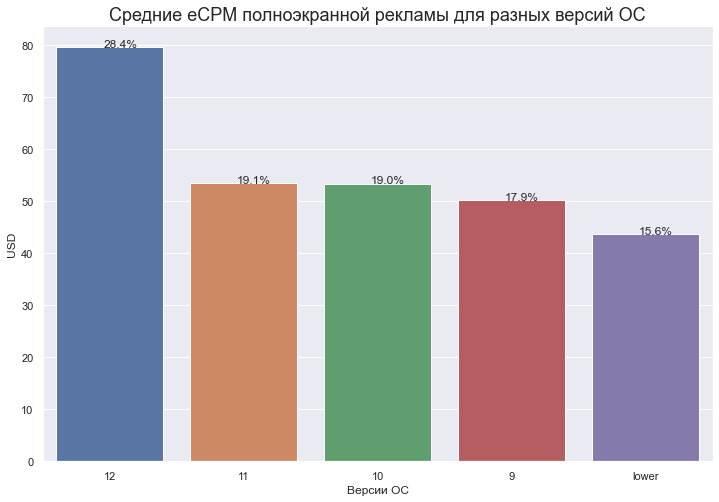

In [156]:
ax = sns.barplot(x=rv_os_df.index, y='eCPM', data=rv_os_df)

plt.ylabel('USD')
plt.xlabel('Версии ОС')
plt.title('Средние eCPM полноэкранной рекламы для разных версий ОС', fontsize=18)

add_percentage(ax, rv_os_df['eCPM'] / rv_os_df['eCPM'].sum())

In [157]:
pearson_corr(rv_os_df['count'], rv_os_df['eCPM'])

stat=0.895, p=0.040
Два параметра вероятнее всего зависимы


In [158]:
tukey(rv_df, 'revenue', 'os_version')

group1,group2,meandiff,p-adj,lower,upper,reject
10,11,0.0,1.0,-0.0079,0.008,False
10,12,0.0262,-0.0,0.0187,0.0338,True
10,9,-0.0032,0.9535,-0.0154,0.009,False
10,lower,-0.0097,0.6463,-0.029,0.0096,False
11,12,0.0262,-0.0,0.0203,0.0321,True
11,9,-0.0032,0.9352,-0.0145,0.008,False
11,lower,-0.0097,0.6145,-0.0285,0.009,False
12,9,-0.0294,0.0,-0.0403,-0.0185,True
12,lower,-0.0359,0.0,-0.0545,-0.0174,True
9,lower,-0.0065,0.9139,-0.0274,0.0143,False


Есть стат значимая разница между средней выручкой с видео рекламы между 12 версией и остальными.

То есть можно сказать, что 12 версия стат значимо имеет среднюю выручку (и соответственно eCPM) выше чем у остальных версий ОС.

Разницу между остальными версиями подтвердить на имеющихся данных не удалось. Имеет смысл повторить рассчеты имея больше данных о показах видео рекламы.

#### Суммарные доходы по городам и версиям ОС

In [159]:
sum_mean, sum_median = get_mean_median(rv_city_df, column='sum')

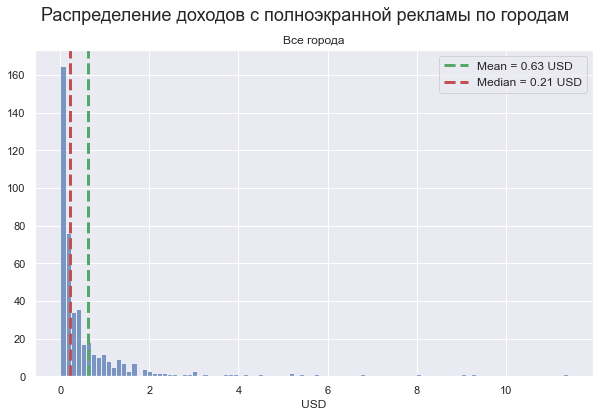

In [160]:
build_hist(x=rv_city_df['sum'], 
           suptitle='Распределение доходов с полноэкранной рекламы по городам', 
           title='Все города',
           mean=sum_mean,
           median=sum_median)

В среднем каждый город заработал 0.63 USD, однако из-за малого числа показов видео рекламы и большого числа городов лучше ориентироваться на медиану — 0.21 USD доходов на город.

Выведу топ 20 городов по доходам

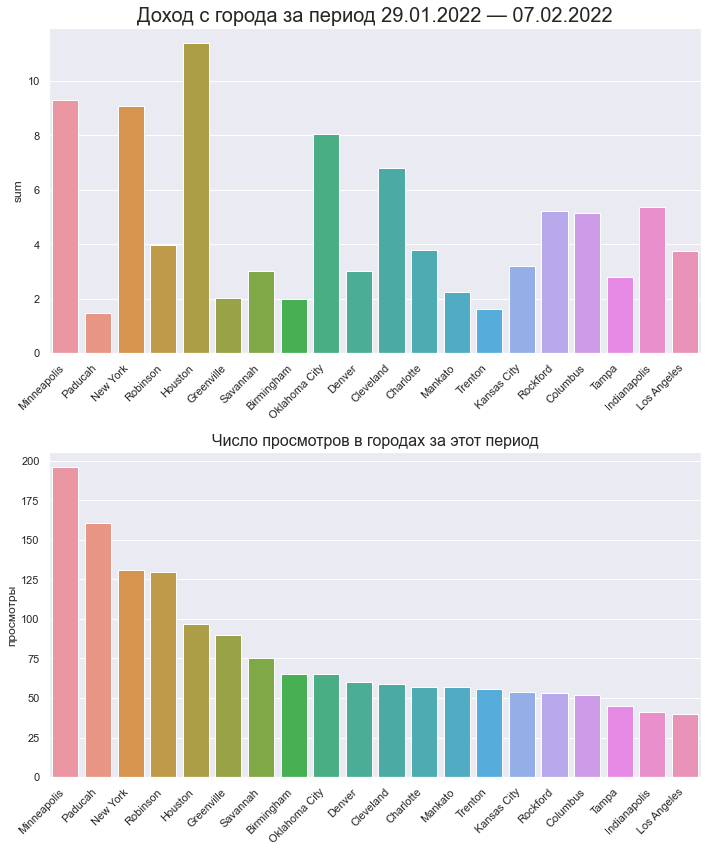

In [161]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

sns.barplot(x=top20_rv_cities.index, y='sum', data=top20_rv_cities, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[0].set_title('Доход с города за период 29.01.2022 — 07.02.2022', size=20)
axs[0].set_xlabel('')

sns.barplot(x=top20_rv_cities.index, y='count', data=top20_rv_cities, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[1].set_title('Число просмотров в городах за этот период', size=16)
axs[1].set_ylabel('просмотры')
axs[1].set_xlabel('')

fig.tight_layout()
plt.show()

Построю аналогичный график для доходов по версиям ОС

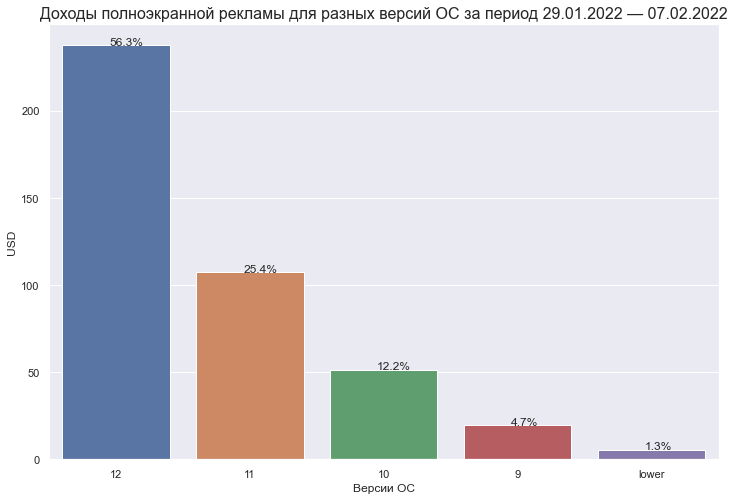

In [162]:
ax = sns.barplot(x=rv_os_df.index, y='sum', data=rv_os_df)

plt.ylabel('USD')
plt.xlabel('Версии ОС')
plt.title('Доходы полноэкранной рекламы для разных версий ОС за период 29.01.2022 — 07.02.2022', fontsize=16)

add_percentage(ax, rv_os_df['sum'] / rv_os_df['sum'].sum())

Больше всего денег с показов видео рекламы принесла 12 версия ОС.

# Вывод

В ходе работы я изучил данные о показе рекламы трех видов пользователям мобильной игры.

Я детально исследовал зависимость между средним eCPM, локацией пользователей (городами) и версией ОС для каждого из видов рекламы.

Удалось выяснить, что игра наиболее популярна среди пользователей телефонов Samsung — 76% всех устройств принадлежит этому производителю.\
Большая часть пользователей играет в игру с телефонов — 92.4%, на планшеты приходится только 7.6% аудитории.
Популярнее всего игра на версии двенадцатой версии ОС — 44% пользователей имеют её. 

Имеется связь между средним eCPM и версией ОС. Так, для всех трех видов рекламы средний eCPM статистически значимо выше для двенадцатой версии ОС.\
Разница между 11, 10 и 9 версиями менее явная, но можно с уверенностью сказать, что версии ОС ниже девятой стат значимо имеют меньший eCPM чем остальные версии.

Также удалось заметить, что версии ОС ниже девятой почти не генерируют прибыли, ими пользуется менее 3% пользователей и для каждой категории рекламы они генерируют не более 2% прибыли.\
Если поддержание этих версий ОС требует дополнительных усилий от команды разработки, то, возможно, имеет смысл прекратить их поддержку.

Наблюдается некоторая связь между локацией и средним eCPM. Так, Индианаполис имеет самый высокий средний eCPm по всем трем категориям, то есть показы всех типов рекламы генерируют больше прибыли в этом городе в сравнении со всеми остальными городами.

Интересное наблюдение — несмотря на то, что наиболее часто показываемой рекламой являются баннеры показываемые во время игры — 95% всех рекламных показов, они генерируют лишь 25.4% прибыли.\
Больше всех денег принесла полноэкранная реклама, которая имеет средний eCPM в 39 раз выше чем у баннеров.\
Несмотря на то, что эта реклама составляет лишь 4.4% от всех рекламных показов, она принесла 57% прибыли.

Видео-реклама обладает самым высоким средним eCPM, но показывается редко. Не удалось получить стат значимые результаты при сравнении eCPM по городам, на мой взгляд это вызвано как раз малым числом записей о показах такой рекламы в имеющихся данных.

Однако по имеющимся данным уже можно судить, что эта реклама работает эффективно, генерируя 17.6% прибыли при том, что суммарное число показов менее 1% (0.8%).\
Возможно, имеет смысл поэкспериментировать с увеличением числа просмотров видео-рекламы пользователями.\
Могу предложить следующие гипотезы для дальнейшей проверки:
- Можно иногда показывать видео-рекламу вместо полноэкранной рекламы 
- Можно увеличить бонусы получаемые за просмотр видео-рекламы

По имеющимся данным у меня сложилось впечатление, что в видео-рекламе может быть потенциальная точка роста прибыли компании. Для проведения углубленного исследования видео-рекламы я запросил бы информацию о ее показах за более длительный период.

Отвечая на вопрос из секции дополнительных заданий:
    
- 63.58% процентов дохода содержат информацию о городе юзера.
- 36.42% процентов дохода не содержат информацию о городе юзера.